# Setup

In [11]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [13]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [14]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

Animal_ID Task Cohort  Probe_Control Sex   Sac_Date Frozen_Hemisphere  \
0        A3   RF      A              0   F  1/27/2021                 R   
1        A4   RF      A              0   F  1/27/2021                 R   
2        A5   RF      A              0   F   4/6/2021                 L   
3        A6   RF      A              0   F   4/6/2021                 R   
4        A7   RF      A              0   F  4/19/2021                 L   

         DOB  Age_WholeMonth  Age_ExtraDays  Age_Month  Aged_Days  Age_Group  \
0  4/23/2019              21              4     21.217        645          3   
1  4/23/2019              21              4     21.217        645          3   
2  4/23/2019              23             14     23.487        714          3   
3  4/23/2019              23             14     23.487        714          3   
4  5/29/2019              22             21     22.730        691          3   

   Behavior_Sessions  Neural_Sessions  
0                  6                6  
1                  6                6  
2                  6                6  
3                  6                6  
4                  6                6

In [15]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [16]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [39]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 notebook save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' 

In [18]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

In [20]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
                               
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

In [23]:
''' Load indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded.

Generated in Figure S2 notebook. Please run that before proceeding.

''' 

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
        
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        Aidx = np.load(figs2_folder + Aidx_file)
        Bidx = np.load(figs2_folder + Bidx_file)
        A_idx = np.load(figs2_folder + A_idx_file)
        B_idx = np.load(figs2_folder + B_idx_file)
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx

        #Also load A`& B` indices excluding gain change trials in each context
        A_ngidx = np.load(figs2_folder + A_ngidx_file)
        B_ngidx = np.load(figs2_folder + B_ngidx_file)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx

In [24]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


# Load classified grid, non-grid spatial, and spatial cells in Figure S2.

In [25]:
''' If you have previously classified grid & ngs cells, run this cell instead of the one above. 
Load saved grid & ngs cell booleans.

'''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')

        #load spatial cells & interneuron booleans
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        d['spatialcell99'] = np.load(figs2_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        
        #load grid & NGS cell booleans
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(figs2_folder + gridcell_file)
        
        ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        ngscell = np.load(figs2_folder + ngscell_file)
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 8 , 50
A14, 083122_record2 n grid, ngs cells: 35 , 2
A14, 090122_record3 n grid, ngs cells: 17 , 13


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 4 , 6
A15, 083122_record2 n grid, ngs cells: 86 , 33
A15, 090122_record3 n grid, ngs cells: 89 , 37
A15, 090222_record4 n grid, ngs cells: 128 , 65
A15, 090322_record5 n grid, ngs cells: 37 , 30
A15, 090422_record6 n grid, ngs cells: 24 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 19 , 23
A16, 083122_record2 n grid, ngs cells: 60 , 36
A16, 090122_record3 n grid, ngs cells: 0 , 1
A16, 090222_record4 n grid, ngs cells: 12 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 1 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 6
A17, 082522_record3 n grid, ngs cells: 40 , 35
A17, 082622_record4 n grid, ngs cells: 42 , 17
A17, 082722_record5 n grid, ngs cells: 32 , 21
A17, 082822_record6 n grid, ngs cells: 54 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 13 , 10
A18, 082422_record2 n grid, ngs cells: 66 , 169
A18, 082522_record3 n grid, ngs cells: 68 , 117
A18, 082622_record4 n grid, ngs cells: 44 , 64
A18, 082722_record5 n grid, ngs cells: 47 , 10
A18, 082822_record6 n grid, ngs cells: 0 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 17 , 1
A19, 012823_record3 n grid, ngs cells: 22 , 75
A19, 012923_record4 n grid, ngs cells: 34 , 64
A19, 013023_record5 n grid, ngs cells: 54 , 38
A19, 013123_record6 n grid, ngs cells: 35 , 18
A19, 020123_record7 n grid, ngs cells: 54 , 31


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 3 , 18
A20, 012723_record2 n grid, ngs cells: 24 , 50
A20, 012823_record3 n grid, ngs cells: 69 , 56
A20, 012923_record4 n grid, ngs cells: 21 , 42
A20, 013023_record5 n grid, ngs cells: 22 , 55
A20, 013123_record6 n grid, ngs cells: 9 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 58 , 39
A22, 013023_record3 n grid, ngs cells: 79 , 122
A22, 013123_record4 n grid, ngs cells: 55 , 46
A22, 020123_record5 n grid, ngs cells: 10 , 12
A22, 020223_record6 n grid, ngs cells: 31 , 38
A22, 020323_record7 n grid, ngs cells: 12 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 4 , 10
A23, 021023_record2 n grid, ngs cells: 27 , 63
A23, 021123_record3 n grid, ngs cells: 29 , 66
A23, 021223_record4 n grid, ngs cells: 9 , 3
A23, 021323_record5 n grid, ngs cells: 27 , 38
A23, 021423_record6 n grid, ngs cells: 50 , 54


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 41 , 34
A24, 022723_record2 n grid, ngs cells: 108 , 65
A24, 022823_record3 n grid, ngs cells: 61 , 63
A24, 030123_record4 n grid, ngs cells: 66 , 37
A24, 030223_record5 n grid, ngs cells: 53 , 26
A24, 030323_record6 n grid, ngs cells: 20 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 69 , 91
MA10F, 111422_record2 n grid, ngs cells: 52 , 48
MA10F, 111522_record3 n grid, ngs cells: 38 , 24
MA10F, 111622_record4 n grid, ngs cells: 19 , 24
MA10F, 111722_record5 n grid, ngs cells: 17 , 28
MA10F, 111822_record6 n grid, ngs cells: 39 , 61


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 33 , 25
MA1F, 102422_record2 n grid, ngs cells: 53 , 28
MA1F, 102522_record3 n grid, ngs cells: 48 , 21
MA1F, 102622_record4 n grid, ngs cells: 9 , 8
MA1F, 102722_record5 n grid, ngs cells: 71 , 52
MA1F, 102822_record6 n grid, ngs cells: 72 , 28


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 47 , 76
MA2F, 102422_record2 n grid, ngs cells: 38 , 103
MA2F, 102522_record3 n grid, ngs cells: 50 , 110
MA2F, 102622_record4 n grid, ngs cells: 39 , 65
MA2F, 102722_record5 n grid, ngs cells: 38 , 43
MA2F, 102822_record6 n grid, ngs cells: 40 , 49


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 6 , 22
MA3M, 102422_record2 n grid, ngs cells: 28 , 53
MA3M, 102522_record3 n grid, ngs cells: 36 , 47
MA3M, 102622_record4 n grid, ngs cells: 13 , 55
MA3M, 102722_record5 n grid, ngs cells: 12 , 30
MA3M, 102822_record6 n grid, ngs cells: 31 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 24 , 68
MA4M, 110122_record3 n grid, ngs cells: 29 , 27
MA4M, 110222_record4 n grid, ngs cells: 8 , 13
MA4M, 110322_record5rep n grid, ngs cells: 26 , 18
MA4M, 110422_record6 n grid, ngs cells: 36 , 35
MA4M, 110522_record7 n grid, ngs cells: 12 , 9


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 58 , 30
MA5M, 110722_record2 n grid, ngs cells: 62 , 55
MA5M, 110822_record3 n grid, ngs cells: 79 , 30
MA5M, 110922_record4 n grid, ngs cells: 7 , 11
MA5M, 111022_record5 n grid, ngs cells: 23 , 25
MA5M, 111122_record6 n grid, ngs cells: 22 , 23


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 22 , 75
MA6M, 103122_record2 n grid, ngs cells: 17 , 39
MA6M, 110122_record3 n grid, ngs cells: 64 , 66
MA6M, 110222_record4 n grid, ngs cells: 7 , 13
MA6M, 110322_record5 n grid, ngs cells: 10 , 6
MA6M, 110422_record6 n grid, ngs cells: 39 , 31


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 31 , 36
MA7M, 103122_record2 n grid, ngs cells: 32 , 56
MA7M, 110122_record3 n grid, ngs cells: 19 , 28
MA7M, 110222_record4 n grid, ngs cells: 7 , 7


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 19 , 8
MA8F, 111422_record2 n grid, ngs cells: 62 , 67
MA8F, 111522_record3 n grid, ngs cells: 80 , 26
MA8F, 111622_record4 n grid, ngs cells: 25 , 37
MA8F, 111722_record5 n grid, ngs cells: 10 , 29
MA8F, 111822_record6 n grid, ngs cells: 12 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 56 , 29
MA9F, 111422_record2 n grid, ngs cells: 73 , 169
MA9F, 111522_record3 n grid, ngs cells: 119 , 80
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 24 , 34
MA9F, 111822_record6 n grid, ngs cells: 23 , 16


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 7 , 7
Y20, 092622_record2 n grid, ngs cells: 32 , 39
Y20, 092722_record3 n grid, ngs cells: 13 , 10
Y20, 092822_record4 n grid, ngs cells: 51 , 33
Y20, 092922_record5 n grid, ngs cells: 19 , 14
Y20, 093022_record6 n grid, ngs cells: 85 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 103 , 76
Y21, 091922_record2 n grid, ngs cells: 80 , 93
Y21, 092022_record3 n grid, ngs cells: 49 , 23
Y21, 092122_record4 n grid, ngs cells: 60 , 62
Y21, 092222_record5 n grid, ngs cells: 42 , 50
Y21, 092322_record6 n grid, ngs cells: 8 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 85 , 57
Y22, 092622_record2 n grid, ngs cells: 146 , 66
Y22, 092722_record3 n grid, ngs cells: 60 , 84
Y22, 092822_record4 n grid, ngs cells: 24 , 21
Y22, 092922_record5 n grid, ngs cells: 20 , 25
Y22, 093022_record6 n grid, ngs cells: 60 , 36


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 38 , 27
Y23, 092622_record2 n grid, ngs cells: 33 , 23
Y23, 092722_record3 n grid, ngs cells: 30 , 40
Y23, 092822_record4 n grid, ngs cells: 26 , 32
Y23, 092922_record5 n grid, ngs cells: 41 , 49
Y23, 093022_record6 n grid, ngs cells: 60 , 84


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 91 , 64
Y24, 091922_record2 n grid, ngs cells: 28 , 69
Y24, 092022_record3 n grid, ngs cells: 97 , 49
Y24, 092122_record4 n grid, ngs cells: 94 , 64
Y24, 092222_record5 n grid, ngs cells: 66 , 44
Y24, 092322_record6 n grid, ngs cells: 70 , 43


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 85 , 37
Y25, 021823_record3 n grid, ngs cells: 29 , 64
Y25, 021923_record4 n grid, ngs cells: 38 , 49
Y25, 022023_record5 n grid, ngs cells: 49 , 46
Y25, 022123_record6 n grid, ngs cells: 18 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 34 , 47
Y26, 021723_record2 n grid, ngs cells: 51 , 22
Y26, 021823_record3 n grid, ngs cells: 23 , 32
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 17 , 19
Y26, 022123_record6 n grid, ngs cells: 4 , 3


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 53 , 44
Y27, 021723_record2 n grid, ngs cells: 39 , 17
Y27, 021823_record3 n grid, ngs cells: 31 , 18
Y27, 021923_record4 n grid, ngs cells: 19 , 20
Y27, 022023_record5rep n grid, ngs cells: 48 , 26
Y27, 022123_record6 n grid, ngs cells: 65 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 4 , 32
Y28, 022723_record2 n grid, ngs cells: 41 , 58
Y28, 022823_record3 n grid, ngs cells: 48 , 45
Y28, 030123_record4 n grid, ngs cells: 20 , 33
Y28, 030223_record5 n grid, ngs cells: 40 , 75
Y28, 030323_record6 n grid, ngs cells: 65 , 48


In [26]:
''' Get counts of grid vs ngs cells by age group '''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2441 2035 2032
2154 2347 2058


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
14.8296889586848 0.6177677242640354 15.167797844277539 0.5583139064062825


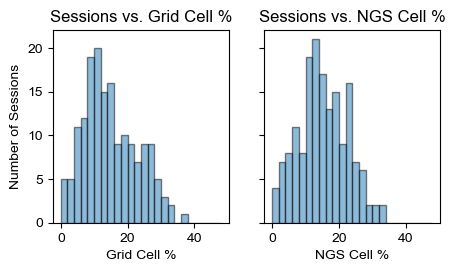

In [27]:
''' Examine grid & NGS cell densities quickly as a sanity check'''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [28]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [29]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mpergrid[y_ind], mpergrid[ma_ind], mpergrid[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Plot figures visualizing spatial firing patterns relative to VR contexts & verifying classification of grid vs. NGS cells (Figures 2A-E & S3A-E)

Not required to run subsequent sections of this notebook.

  0%|          | 0/6 [00:00<?, ?it/s]

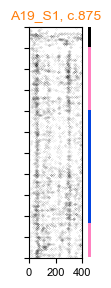

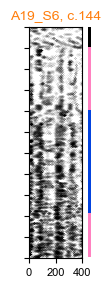

  0%|          | 0/6 [00:00<?, ?it/s]

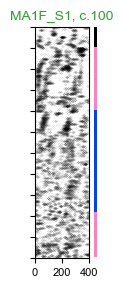

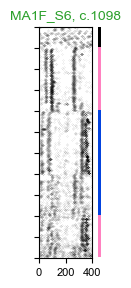

  0%|          | 0/6 [00:00<?, ?it/s]

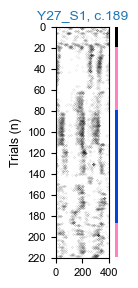

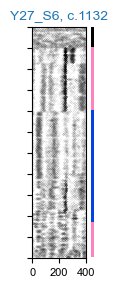

In [30]:
''' Sequentially Plot Example Grid Cell Rasters (Figure 2A)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_gridcells = [875,144,100,1098,189,1132]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_gridcells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.set_xticks([0,200,400])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '2A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

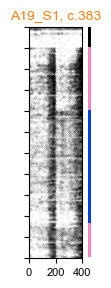

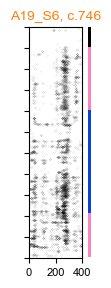

  0%|          | 0/6 [00:00<?, ?it/s]

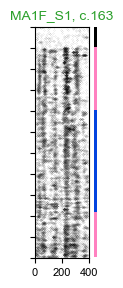

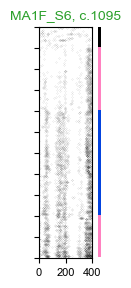

  0%|          | 0/6 [00:00<?, ?it/s]

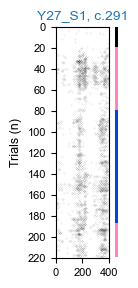

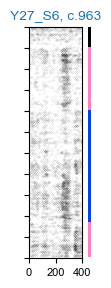

In [31]:
''' Sequentially Plot Example Non-Grid Spatial Cell Rasters (Figure S3A)'''

switches = [-20, -80]
colors = ['xkcd:pink','xkcd:blue']
labels = ['Context A','Context B']
CLU_W = 3

from matplotlib.lines import Line2D
from copy import copy
count = 0
cellcount = 0

ex_mice = ['Y27','MA1F','A19'] # mouse names for Fig 2 / S3 examples
ex_sessions = ['021623_record1','022123_record6','102322_record1','102822_record6',
               '012723_record2','020123_record7'] #list of sssions

ex_ngscells = [383,746,163,1095,291,963]
minimalistbool = [True,True,True,True,False,True]
sesh = [1,6,1,6,1,6]
cols = ['C1','C1','C2','C2','C0','C0']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue 
            
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posx = behaviorfil[:,0]
        reward = raw.item().get('reward')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        rawtrialfil = raw.item().get('trialfil')
        trial = behaviorfil[:,2]
    
        # Find skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        trials = np.unique(trial)
        alltrial = np.arange(0, 220 ,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #binary context vector, excluding skipped trials, dark, & gain periods, 1 = Map A
        context = []
        for i, t in enumerate(np.unique(skippedrawtrialfil)):
            if t < 220:
                context = np.append(context, leftsort[t.astype(int)])

        #Reverse y-axis
        skippedrawtrialfil = -1 * skippedrawtrialfil
        newskippedtrials = -1 * newskippedtrials

        ## PLOT RASTER w/ CONTEXT LABEL
        c = ex_ngscells[cellcount]
        minimalist = minimalistbool[cellcount]
        col = cols[cellcount]
        
        widths = [20,1]
        heights = [1]
        fig = plt.figure(figsize = (0.8,3))
        gs = gridspec.GridSpec(ncols = 2, nrows = 1, figure=fig, height_ratios = heights, width_ratios = widths)

        sdx = Z[:, np.where(cell_IDs == c)[0][0]].astype(bool)
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(posxcopy[sdx], skippedrawtrialfil[sdx], '.', color = 'k', markersize=0.2, alpha=0.4)
        ax1.set_xlim([0, 400])
        ax1.set_ylim([np.min(skippedrawtrialfil),0])
        ax1.set_yticks([-220,-200,-180,-160,-140,-120,-100,-80,-60,-40,-20,0])
        ax1.set_yticklabels([220,200,180,160,140,120,100,80,60,40,20,0])
        ax1.set_xticks([0,200,400])
        ax1.tick_params(labelsize = 8)
        ax1.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 10, color = col)

        if minimalist == False:
            ax1.set_ylabel('Trials (n)', fontsize = 9)
        else:
            ax1.set_yticklabels([])

        #label skipped trials for transparency
        for z in newskippedtrials:
            ax1.hlines(z,0,400, color = 'lightgrey', linewidth = 0.5, linestyles = 'dotted')

        #label dark trials & trial context at right
        ax2 = fig.add_subplot(gs[1], sharey = ax1)
        for i, t in enumerate(context.astype(bool)):
            if i >= 20:
                if i in newskippedtrials:
                    ax2.vlines(0, -1*i, -1*i + 1, colors='lightgrey', lw= CLU_W, linestyles= 'solid', alpha = 1)
                else:
                    if t == True:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:pink', lw= CLU_W, linestyles= 'solid', alpha = 1)
                    else:
                        ax2.vlines(0, -1*i, -1*i + 1, colors='xkcd:blue', lw= CLU_W, linestyles='solid', alpha = 1)
            else: 
                ax2.vlines(0, -1*i, -1*i + 1, colors='k', lw= CLU_W, linestyles='solid', alpha = 1)

        ax2.axis('off') 
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.png', dpi = 400)
        fig.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + 'S3A.svg', dpi = 400)
        plt.show()
        
        cellcount += 1

  0%|          | 0/6 [00:00<?, ?it/s]

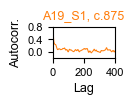

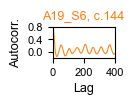

  0%|          | 0/6 [00:00<?, ?it/s]

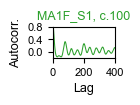

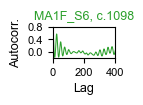

  0%|          | 0/6 [00:00<?, ?it/s]

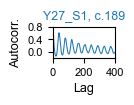

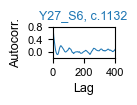

In [36]:
''' Plot dark FR autocorrelation of example grid cells (Figure 2B)'''

cellcount = 0
n_dark = 20 #trials
lags = np.arange(0,801,1)

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig,ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.set_xticks([0,200,400])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + '2B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

  0%|          | 0/6 [00:00<?, ?it/s]

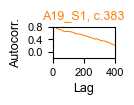

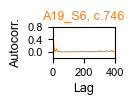

  0%|          | 0/6 [00:00<?, ?it/s]

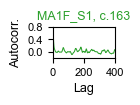

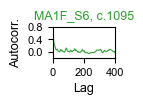

  0%|          | 0/6 [00:00<?, ?it/s]

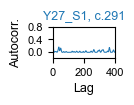

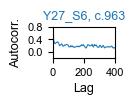

In [37]:
''' Plot dark FR autocorrelation of example non-grid spatial cells (Figure S3B)'''

cellcount = 0

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        d = data[m][s]
    
        if s not in ex_sessions:
            continue 
            
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins

        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')

        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')

        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)

        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        if m in SM_aged_mice:
            col = 'C1'
        elif m in SM_MA_mice:
            col = 'C2'
        else:
            col = 'C0'

        # for example cell, calc autocorrelation & plot
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = np.where(cell_IDs == c)[0][0]
        autocorrelation = get.autocorr(FR[sdx,:],lags)
        normauto = autocorrelation / autocorrelation[0]

        fig, ax = plt.subplots(figsize = (0.8,0.4))
        ax.plot(lags, normauto, color = col, linewidth = 0.75)
        ax.set_title(str(m) + '_S' + str(sesh[cellcount]) + ', c.' + str(c), fontsize = 9, color = col)
        ax.set_xlabel('Lag',fontsize = 9)
        ax.set_ylabel('Autocorr.',fontsize = 9)
        ax.set_xlim([0,400])
        ax.set_ylim([-0.2, 0.8])
        ax.set_yticks([0, 0.4, 0.8])
        ax.set_xticks([0,200,400])
        ax.tick_params(labelsize = 8)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.png', dpi = 400)
        plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_' + 'S3B.svg', dpi = 400)
        plt.show()

        cellcount += 1    

In [40]:
''' Choose a random shuffle rep vs. real distribution of all grid & non-grid cell autocorrelation peak heights

Run time <30s / session.

'''

import random

ngsshuffheights = []
gridshuffheights = []

gridproms = []
ngsproms = []
gridheights = []
ngsheights = []

P99shuffheight = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        cell_IDs = raw.item().get('cellsfil')
        
        #get stuff you will need later to shuffle & re-filter spike times to confirm putative grid spatial cells
        sp = raw.item().get('sp')
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        rawspeed = raw.item().get('speed')
        
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        speed_to_trash = get.find(rawspeed < 2)
        pos_to_trash = get.find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(len(rawspeed)), trash_idx)
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:],lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)
                
        peak = peak.astype(bool)
    
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]  
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder + shufmaxpeak_heights_file)
        
        for i, c in enumerate(cell_IDs):
            idx = np.where(cell_IDs[peak] == c)[0]
            
            if len(idx) == 0:
                P99shuffheight = np.append(P99shuffheight, np.nan)
            else:
                shuffheightP99 = np.percentile(np.ravel(shuffmaxpeak_heights[:,idx]), 99)
                P99shuffheight = np.append(P99shuffheight, shuffheightP99)

        for i, c in enumerate(gridcells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
        
            shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            gridproms = np.append(gridproms, maxpeak_proms[sdx])
            gridheights = np.append(gridheights, maxpeak_heights[sdx])
            gridshuffheights = np.append(gridshuffheights, shuffheight)
            
        for i, c in enumerate(ngscells):
            idx = np.where(cell_IDs[peak] == c)[0]
            sdx = np.where(cell_IDs == c)[0]
            
            if len(idx) > 0:
                shuffheight = np.random.choice(np.ravel(shuffmaxpeak_heights[:,idx]))
            else:
                shuffheight = 0
                
            ngsproms = np.append(ngsproms, maxpeak_proms[sdx])
            ngsheights = np.append(ngsheights, maxpeak_heights[sdx])
            ngsshuffheights = np.append(ngsshuffheights, shuffheight)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
''' Peak Height Thresholds & n model pairs vs. shuffle'''

print('n total cells w/ peaks: ' + str(len(P99shuffheight[~np.isnan(P99shuffheight)])))
print('% total cells w/ significant peaks: ' + str(100*len(P99shuffheight[~np.isnan(P99shuffheight)])/43388))

print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99shuffheight)) + ', ' + str(stats.sem(P99shuffheight, nan_policy = 'omit')))
print('n grid, NGS model pairs: ' + str(len(gridheights)) + ', ' + str(len(ngsheights)))

n total cells w/ peaks: 17498
% total cells w/ significant peaks: 40.329123259887524
mean ± SEM coherence shuffle P99: 0.2017224122142725, 0.0009507379791441329
n grid, NGS model pairs: 6508, 6559


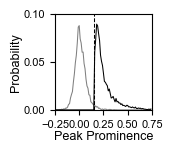

Mean, SEM Real:
0.2534256169200522 0.001305304064766415

Mean, SEM Shuffle:
0.008281165531114932 0.0007499522368140221

stat = 736.0
p_cells = 0.0


In [42]:
'''Plot Figure 2C + Display Stats'''
bins = np.arange(-0.25,0.75,0.01)
gproms, bin_edges = np.histogram(gridproms, bins = bins)
pdf = gproms / sum(gproms)

shuffgheights, shuffbin_edges = np.histogram(gridshuffheights, bins = bins)
shuffpdf = shuffgheights / sum(shuffgheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.vlines(0.15,0,0.75, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.10])
ax.set_yticks([0, 0.05,0.10])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + '2C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(gridproms), stats.sem(gridproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(gridshuffheights), stats.sem(gridshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(gridproms, gridshuffheights)
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

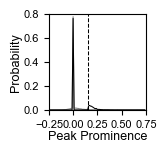

Mean, SEM Real:
0.0472958240195668 0.001072784178337035

Mean, SEM Shuffle:
0.01175750628627305 0.00066054831909499

stat = 51720.0
p_cells = 2.3187914578224396e-217


In [43]:
''' Plot Figure S3C'''
bproms, bin_edges = np.histogram(ngsproms, bins = bins)
pdf = bproms / sum(bproms)

shuffbheights, shuffbin_edges = np.histogram(ngsshuffheights, bins = bins)
shuffpdf = shuffbheights / sum(shuffbheights)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9, labelpad = 1)
ax.set_xlabel('Peak Prominence', fontsize = 9, labelpad = 1)
ax.vlines(0.15,0,0.8, colors ='k', linewidths = 0.75, linestyles = '--')
ax.set_xlim([-0.25,0.75])
ax.set_xticks([-0.25,0,0.25,0.5,0.75])
ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S3C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3C.svg', dpi=400, bbox_inches='tight')
plt.show()

print('Mean, SEM Real:')
print(np.nanmean(ngsproms), stats.sem(ngsproms, nan_policy = 'omit')) 
print('\nMean, SEM Shuffle:')
print(np.nanmean(ngsshuffheights), stats.sem(ngsshuffheights, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(ngsproms[~np.isnan(ngsshuffheights)], ngsshuffheights[~np.isnan(ngsshuffheights)])
print('\nstat = ' + str(stat))
print('p_cells = ' + str(p_diff))

In [44]:
'''Calculate Grid vs. NGS Cell Density by Age Group'''
dt = 0.02

# set up arrays for plotting by session 
spergrid = [] 
sperngs = []

# by animal
mpergrid = [] 
mperngs = []

for m, session in zip(mice,sessions):
    
    m_grid = [] 
    m_ngs = []
    m_cells = []

    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #get cell IDs, filtered behavioral/spike data, & relevant score
        gridcell = d['gridcell'].astype(bool)
        ngscell = d['ngscell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        ngscells = cell_IDs[ngscell]
        
        #Calculate Cell Densities
        sperngs = np.append(sperngs, 100 * len(ngscells)/len(cell_IDs))
        spergrid = np.append(spergrid, 100 * len(gridcells)/len(cell_IDs))

        #save data to be pooled by mouse    
        m_grid = np.append(m_grid, len(gridcells)) 
        m_ngs = np.append(m_ngs, len(ngscells)) 
        m_cells = np.append(m_cells, len(cell_IDs))
       
    # pool data by animal     
    mpergrid = np.append(mpergrid, 100*np.sum(m_grid)/np.sum(m_cells)) 
    mperngs = np.append(mperngs, 100*np.sum(m_ngs)/np.sum(m_cells)) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

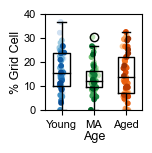


GRID CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
16.17 ± 1.14 ; 13.38 ± 0.79 ; 15.05 ± 1.24
F = 2.5862538000415984
p_grid%session = 0.27441138320138


In [45]:
'''Grid Cell Density Young vs. Aged Session by Age Group (Figure 2D) + Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Grid Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Grid Cell', fontsize=9, labelpad=1)
ax.set_ylim([0,40])
ax.tick_params(labelsize = 8)

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '2D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nGRID CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(spergrid[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid[age_sind]), 2)))

stat, p_diff = stats.kruskal(spergrid[y_sind],spergrid[ma_sind],spergrid[age_sind])
print('F = ' + str(stat))
print('p_grid%session = ' + str(p_diff))

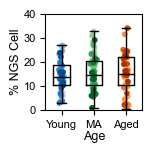


NGS CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
14.59 ± 0.87 ; 15.73 ± 0.95 ; 15.14 ± 1.08
F = 0.4809290162273214
p_ngs%session = 0.7862625508939945


In [46]:
'''NGS Cell Density Young vs. Aged Session by Age Group (Figure S3D) + Stats'''

fig, ax = plt.subplots(figsize = (1.25,1.25))
pergrid = [sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(pergrid, widths = w, labels = labels, medianprops = dict(color = 'black'))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% NGS Cell', fontsize=9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,40])

for i in range(len(pergrid)):
    y = pergrid[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + 'S3D.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3D.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nNGS CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperngs[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperngs[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperngs[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperngs[y_sind],sperngs[ma_sind],sperngs[age_sind])
print('F = ' + str(stat))
print('p_ngs%session = ' + str(p_diff))

  0%|          | 0/6 [00:00<?, ?it/s]

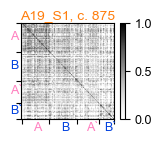

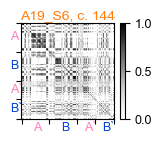

  0%|          | 0/6 [00:00<?, ?it/s]

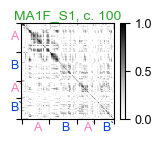

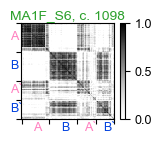

  0%|          | 0/6 [00:00<?, ?it/s]

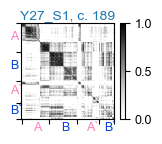

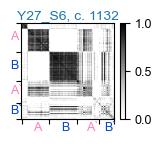

In [47]:
''' Plot example grid cell cross trial correlation matrices (Figure 2E) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_gridcells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_S{}, c. {}'.format(m, sesh[cellcount], c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_2E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                                    

  0%|          | 0/6 [00:00<?, ?it/s]

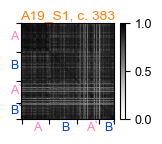

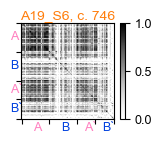

  0%|          | 0/6 [00:00<?, ?it/s]

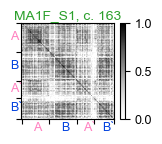

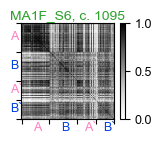

  0%|          | 0/6 [00:00<?, ?it/s]

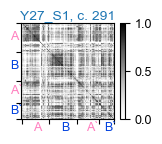

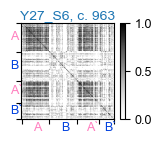

In [48]:
''' Plot example NGS cell cross trial correlation matrices (Figure S3e) '''

cellcount = 0

colors = ['xkcd:pink','xkcd:blue','xkcd:pink', 'xkcd:blue']
labels = ['A', 'B','A`','B`']

for m, session in zip(mice,sessions):
    
    if m not in ex_mice:
        continue
    
    for s in tdqm(session):
        
        if s not in ex_sessions:
            continue

        d = data[m][s]
    
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    

        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        rawtrialfil = raw.item().get('trialfil')
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']

        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []

        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        # add ticks to label contexts dynamically
        lengthdark = (20 - ndarkskipped)
        lengthA = len(numtrial[numtrial < (80 - lengthdark)])
        nA_ = np.sum(1 - leftsort[alltrial >= 140])
        lengthB = len(numtrial[(numtrial >= (80 - lengthdark)) & (numtrial < (140 - lengthdark))])
        lengthA_ = len(numtrial[(numtrial >= (140 - lengthdark)) & (numtrial < (140 + nA_ - lengthdark))])
        end =  len(np.unique(skippedrawtrialfil[:end_idx])) - lengthdark
        nB_ = end - (lengthA + lengthB + lengthA_) 
        
        ticks = np.array([0, lengthA, (lengthA + lengthB), (lengthA + lengthB + lengthA_), end])
        textloc = np.array([lengthA // 2, (lengthA + lengthB // 2), (lengthA + lengthB + lengthA_//2), (lengthA + lengthB + lengthA_ + nB_//2)])

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        c = ex_ngscells[cellcount]
        col = cols[cellcount]
        sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
        sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 

        f = plt.figure(figsize=(1.5, 1.25))
        ax0 = plt.subplot()
        im = ax0.imshow(sim, clim=[0, 1.0], aspect='auto', cmap='Greys')
        ax0.set_title('{}_S{}, c. {}'.format(m,sesh[cellcount],c), fontsize=10, color = col, pad=3)
        ax0.set_yticks(ticks, labels = [])
        ax0.set_xticks(ticks, labels = [])
        for n, j in enumerate(labels):
            ax0.text(textloc[n] - 5, 225, j, color = colors[n], fontsize = 9)
            ax0.text(-25, textloc[n] + 5, j, color = colors[n], fontsize = 9)
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize = 9)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.png', dpi = 400)
        f.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_S3E.svg', dpi = 400)
        plt.show()
        
        cellcount += 1 
                               

# Examine Grid Cell Stability & Similarity Ratio (Context-Specificity). Plot Figures 2F-I. 

You can skip to this session after setting up and loading in grid cell booleans. 

In [61]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Grid Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''
for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(gridcells)))
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allgridsim'] = allsim
                               
        allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allgridsim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [49]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#session arrays
slocstab5block = []
slocstab5alt = []

max_k = 5

#cell arrays
ylocstab5block = []
ylocstab5alt = []

malocstab5block = []
malocstab5alt = []

alocstab5block = []
alocstab5alt = []

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        
        allgridsim_file = 'allsim_' + m + '_' + s + '_'+ '.npy'
        d['allgridsim'] = np.load(save_folder + allgridsim_file)
        allgridsim = d['allgridsim']
        
        local_stabilityblock = [] 
        local_stabilityalt = []
        for i, c in enumerate(gridcells):
            
            #divide sim by context
            sim = allgridsim[:,:,i]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
#save arrays
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8124\1743908464.py:84: RuntimeWarning: Mean of empty slice
  slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
C:\Users\Python\AppData\Local\Temp\ipykernel_8124\1743908464.py:85: RuntimeWarning: Mean of empty slice
  slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [50]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
    
            
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6508      Method:               REML         
No. Groups:           29        Scale:                0.0145       
Min. group size:      60        Log-Likelihood:       1847.9229    
Max. group size:      446       Converged:            Yes          
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.332    0.038  8.859 0.000  0.259  0.406
C(AgeGroup)[T.2.0]       -0.112    0.057 -1.966 0.049 -0.223 -0.000
C(AgeGroup)[T.3.0]        0.004    0.045  0.095 0.925 -0.084  0.093
C(Sex)[T.M]               0.025    0.060  0.415 0.678 -0.092  0.141
C(Cohort)[T.D]           -0.012    0.074 -0.157 0.876 -0.156  0

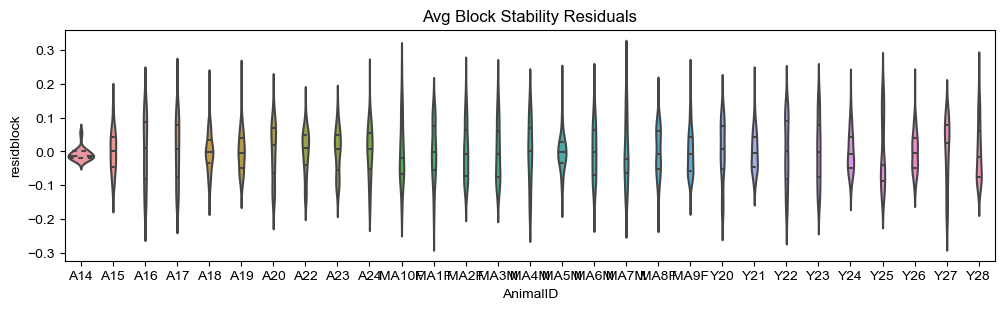

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6508       Method:                REML       
No. Groups:           29         Scale:                 0.0064     
Min. group size:      60         Log-Likelihood:        4557.4891  
Max. group size:      446        Converged:             Yes        
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.133    0.026  5.147 0.000  0.083  0.184
C(AgeGroup)[T.2.0]       -0.065    0.039 -1.664 0.096 -0.143  0.012
C(AgeGroup)[T.3.0]        0.048    0.031  1.527 0.127 -0.013  0.108
C(Sex)[T.M]               0.031    0.041  0.749 0.454 -0.050  0.112
C(Cohort)[T.D]           -0.016    0.051 -0.308 0.758 -0.116  0

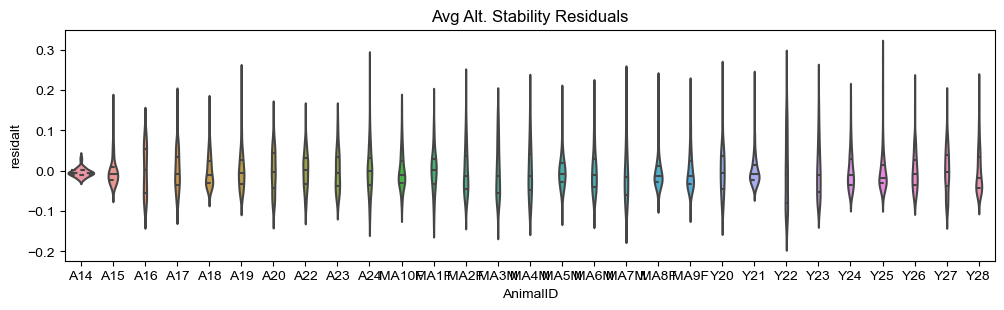

In [51]:
''' LMMs for Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
#print(malt.aic)
#print(malt.bic)

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [52]:
''' Report Raw & Fitted Alternation Stability by Animal for Figure 8'''

df['fitted'] = malt.fittedvalues
animalgrouped = df.groupby(['AnimalID'])
animal = np.array(animalgrouped['fitted'].mean())

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['locstab5alt'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('Stability First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
print('Stability Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

print('\nRaw Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('Stability First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['locstab5alt'].mean().to_string(index = True))
print('Stability Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['locstab5alt'].mean().to_string(index = True))


Raw Data Mean across All Sessions by Animal:
AnimalID
A14      0.008633
A15      0.106659
A16      0.204171
A17      0.178320
A18      0.105407
A19      0.154642
A20      0.183172
A22      0.207102
A23      0.166900
A24      0.251970
MA10F    0.123812
MA1F     0.237030
MA2F     0.173006
MA3M     0.222019
MA4M     0.145731
MA5M     0.150645
MA6M     0.183956
MA7M     0.203253
MA8F     0.098815
MA9F     0.128382
Y20      0.243152
Y21      0.077495
Y22      0.310607
Y23      0.199210
Y24      0.141264
Y25      0.080733
Y26      0.146082
Y27      0.211913
Y28      0.129100

Fitted Data Mean across All Sessions by Animal:
AnimalID
A14      0.012297
A15      0.106828
A16      0.203478
A17      0.177963
A18      0.105693
A19      0.154661
A20      0.182974
A22      0.206879
A23      0.166787
A24      0.251599
MA10F    0.123951
MA1F     0.236679
MA2F     0.172919
MA3M     0.221729
MA4M     0.146218
MA5M     0.150776
MA6M     0.184036
MA7M     0.202415
MA8F     0.099151
MA9F     0.128450
Y20   

In [53]:
''' Get fitted block vs. alternation grid stability session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


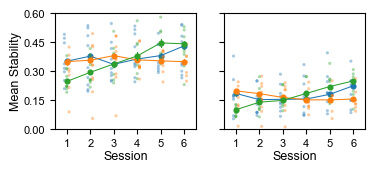

In [54]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6])
ax[0].set_ylim([0.0,0.6])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
ax[1].set_ylim([0.0,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + '2F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [56]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.13526667581561502 0.6120184615567782 0.6530742190283692 0.48935871987366497
P [Young, MA, Aged, All]: 
0.3341830596715891 4.227366551902729e-07 1.1564708858399309e-07 3.387758863377874e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10434818856230203 0.6597356193734476 0.4031473313655896 0.4070187001791263
P [Young, MA, Aged, All]: 
0.4571273812819284 2.3825542708744225e-08 0.0027613753821976433 6.976779477876197e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.37947122726324534 0.6587427008462435 0.7127238065191915 0.5832509814659874
P [Young, MA, Aged, All]: 
6.028456161160926e-05 1.633138885836037e-15 1.0444731154622057e-17 4.21381151304087e-31

n session halves: young, ma, aged
106 114 106


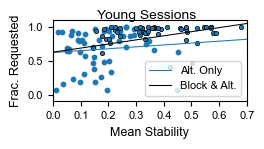

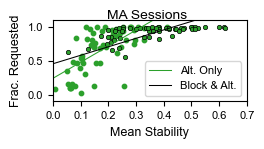

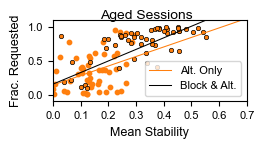

In [57]:
''' Plot Figure 2H with Block & Alt. Data '''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2H_alt1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2H_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2H_alt2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2H_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + '2H_alt3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2H_alt3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.25471499658024316 0.5053215832258462 0.48671234069739255 0.4135914313108569
P [Young, MA, Aged, All]: 
0.13381992522221464 0.0016691395256720472 0.00302801784439132 9.514963734187635e-06

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.1596148888133262 0.7105417639641318 0.38083184528747344 0.44032450343478824
P [Young, MA, Aged, All]: 
0.35243768006856857 1.2036417403416075e-06 0.024007041220624303 2.0742153040103376e-06

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4282297829596701 0.6483860059697665 0.6671342158613451 0.5814380660972089
P [Young, MA, Aged, All]: 
0.00017505297956558729 7.369238298081498e-10 2.8615336622422905e-10 9.460898251915608e-21

n session halves: young, ma, aged
72 72 70


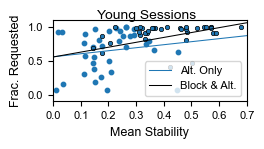

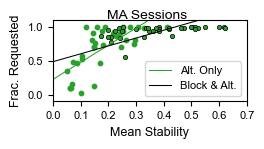

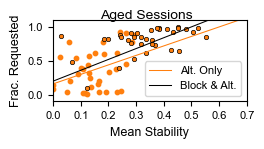

In [42]:
''' Plot Figure 2H with Block & Alt. Data [Subsample Sequenced Mice] '''
allidx = np.concatenate((y_sindgrid_sub, ma_sindgrid_sub, age_sindgrid_sub))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid_sub],slocstab5alt[y_sindgrid_sub])),np.hstack((reqblock_rates[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid_sub],slocstab5alt[ma_sindgrid_sub])),np.hstack((reqblock_rates[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid_sub],slocstab5alt[age_sindgrid_sub])),np.hstack((reqblock_rates[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid_sub)*2,len(ma_sindgrid_sub)*2,len(age_sindgrid_sub)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + '2H_alt1.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2H_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + '2H_alt2.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2H_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.show()

In [101]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allgridsim = d['allgridsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(gridcells):
            sim = allgridsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_14072\1775114978.py:85: RuntimeWarning: Mean of empty slice
  sABratio= np.append(sABratio, np.nanmean(ABratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_14072\1775114978.py:86: RuntimeWarning: Mean of empty slice
  sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_14072\1775114978.py:87: RuntimeWarning: Mean of empty slice
  sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ABratio  
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0333   
Min. group size:      60          Log-Likelihood:         -984.5730
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.193    0.052 23.064 0.000  1.091  1.294
C(AgeGroup)[T.2.0]       -0.108    0.078 -1.375 0.169 -0.261  0.046
C(AgeGroup)[T.3.0]        0.060    0.062  0.962 0.336 -0.062  0.183
C(Sex)[T.M]              -0.033    0.082 -0.405 0.685 -0.193  0.127
C(Cohort)[T.D]            0.058    0.101  0.577 0.564 -0.140  0

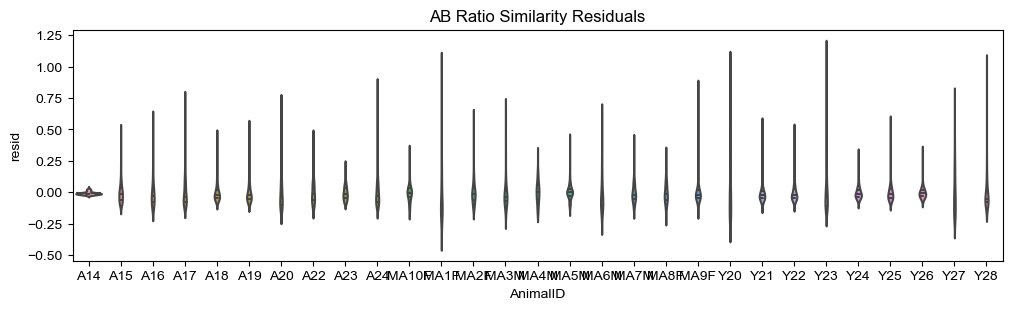

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     A_B_ratio
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0031   
Min. group size:      60          Log-Likelihood:         6615.6986
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.015    0.014 72.367 0.000  0.988  1.043
C(AgeGroup)[T.2.0]       -0.001    0.021 -0.043 0.965 -0.043  0.041
C(AgeGroup)[T.3.0]        0.058    0.017  3.407 0.001  0.025  0.092
C(Sex)[T.M]              -0.003    0.022 -0.149 0.882 -0.046  0.040
C(Cohort)[T.D]            0.019    0.027  0.686 0.492 -0.035  0

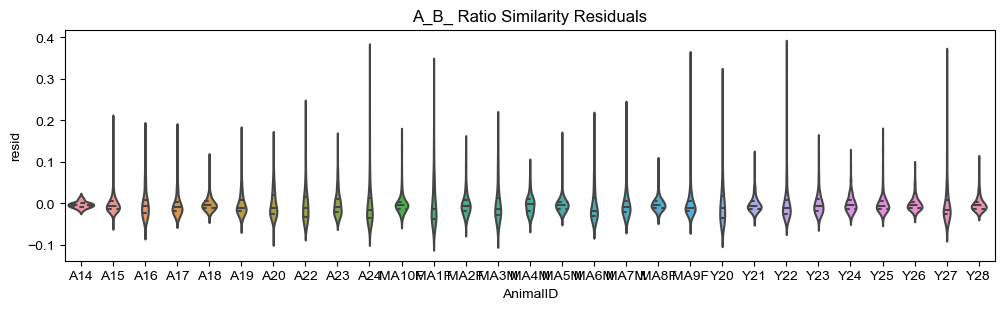

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     AB_ratio 
No. Observations:     6508        Method:                 REML     
No. Groups:           29          Scale:                  0.0038   
Min. group size:      60          Log-Likelihood:         5933.8966
Max. group size:      446         Converged:              Yes      
Mean group size:      224.4                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.011    0.015 67.120 0.000  0.982  1.041
C(AgeGroup)[T.2.0]        0.009    0.023  0.376 0.707 -0.036  0.053
C(AgeGroup)[T.3.0]        0.051    0.018  2.765 0.006  0.015  0.087
C(Sex)[T.M]              -0.013    0.024 -0.545 0.586 -0.059  0.033
C(Cohort)[T.D]            0.017    0.029  0.578 0.564 -0.040  0

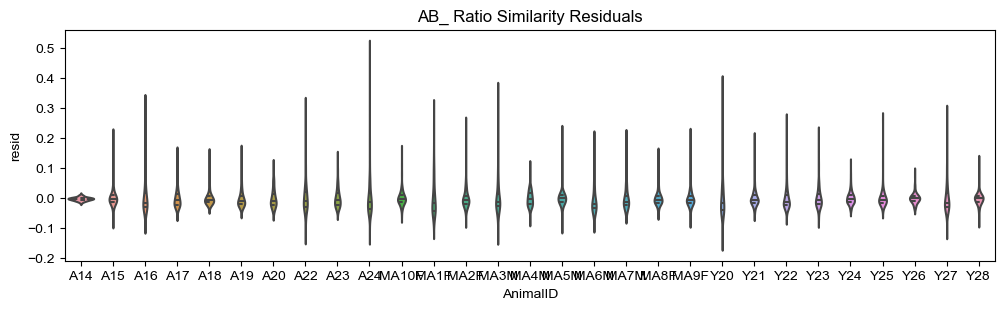

In [117]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))
#print(mAB_.aic)
#print(mAB_.bic)

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [113]:
''' Report Grid Alt. Sim Ratio by Animal for Figure 8 '''

df['mAB_fitted'] = mAB_.fittedvalues
animalgrouped = df.groupby(['AnimalID'])
animal = np.array(animalgrouped['mAB_fitted'].mean())

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['AB_ratio'].mean().to_string(index=False))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['mAB_fitted'].mean().to_string(index=False))

print('\nFitted Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('Sim Ratio First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['mAB_fitted'].mean().to_string(index = False))
print('Sim Ratio Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['mAB_fitted'].mean().to_string(index = True))

print('\nRaw Data Mean across All Sessions by Animal:')
#last3mean = df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_numpy()
#first3mean = df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_numpy()
print('First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['AB_ratio'].mean().to_string(index = False))
print('Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['AB_ratio'].mean().to_string(index = True))

Raw Data Mean across All Sessions by Animal:
AnimalID
1.003252
1.018321
1.101422
1.062927
1.041658
1.050861
1.056558
1.077882
1.075125
1.121786
1.044419
1.158329
1.060646
1.082315
1.029070
1.003135
1.100399
1.069964
1.043992
1.046631
1.129456
1.036759
1.079236
1.054116
1.042805
1.035358
1.028800
1.087044
1.015918

Fitted Data Mean across All Sessions by Animal:
AnimalID
1.005653
1.018627
1.100240
1.062851
1.041861
1.051009
1.056677
1.077725
1.074890
1.121323
1.044680
1.157595
1.060798
1.081984
1.029724
1.003662
1.099774
1.069070
1.044288
1.046797
1.128642
1.036825
1.079011
1.054179
1.042886
1.035659
1.029161
1.086770
1.016566

Fitted Data Mean across All Sessions by Animal:
Sim Ratio First Three: 
AnimalID
1.005653
1.015686
1.106575
1.062385
1.048713
1.050850
1.057407
1.081456
1.057334
1.114240
1.027990
1.105630
1.046823
1.057424
1.023198
0.989521
1.074602
1.070423
1.037823
1.039667
1.104200
1.022446
1.060547
1.011982
1.026705
1.020288
1.025452
1.071127
1.002785
Sim Ratio Last Three: 


In [103]:
''' Get fitted session averages '''
r = 6
df['mAB_fitted'] = mAB_.fittedvalues
resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
#print(resultA_)
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    
    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
   
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
             
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            


aged, MA, young mice on day 1
10 10 8

aged, MA, young mice on day 2
10 10 9

aged, MA, young mice on day 3
9 10 9

aged, MA, young mice on day 4
9 9 9

aged, MA, young mice on day 5
8 9 9

aged, MA, young mice on day 6
7 9 9


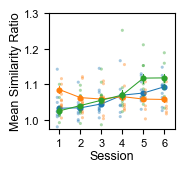

In [57]:
''' Plot Figure 2j [Original Manuscript]'''
f, ax = plt.subplots(1, 1, figsize=(1.625, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_ylim([0.975,1.3])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\naged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    ax.scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#ax.legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + '2J.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2J.svg', dpi=400, bbox_inches='tight')
plt.show()

In [58]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 8

n aged, MA, young mice on day 1 for alt ratio
10 10 8

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
9 10 9

n aged, MA, young mice on day 3 for alt ratio
9 10 9

n aged, MA, young mice on day 4 for block ratio
9 9 9

n aged, MA, young mice on day 4 for alt ratio
9 9 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
7 9 9

n aged, MA, young mice on day 6 for alt ratio
7 9 9


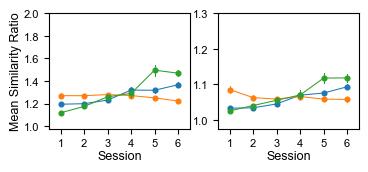

In [83]:
'''Plot Revised Figure 2G (Mean Similarity Ratio)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.2,1.4,1.6,1.8,2])
ax[0].set_ylim([0.975,2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3])
ax[1].set_ylim([0.975,1.3])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + '2G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '2G.svg', dpi=400, bbox_inches='tight')
plt.show()

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.49435556119258633 0.5103690037576075 0.39764618131342777 0.4616641274856602
P [Young, MA, Aged, All]: 
0.00016831333234685502 4.9955054705918986e-05 0.0031930175239869847 5.54894184290362e-10

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.025622202316819734 0.47571641872851056 0.8554034726106997 0.549539301275536
P [Young, MA, Aged, All]: 
0.9478314256796656 0.19554432660430993 0.014104252352027011 0.004434547888363183


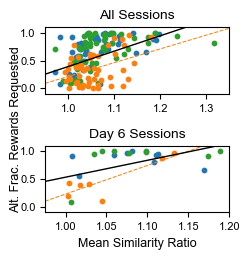

In [90]:
''' Plot Figure 2k '''
### A_ vs. REQ ALT RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid][~np.isnan(sAB_ratio[age_sindgrid])],reqalt_rates[age_sindgrid][~np.isnan(sAB_ratio[age_sindgrid])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
 
#plot all session correlations
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)

ax[0].scatter(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', label = 'Young', s = 10)
ax[0].scatter(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', label = 'MA', s = 10)
ax[0].scatter(sAB_ratio[age_sindgrid][~np.isnan(sAB_ratio[age_sindgrid])],reqalt_rates[age_sindgrid][~np.isnan(sAB_ratio[age_sindgrid])], color = 'C1', s = 10)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0.95,1.35])
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,0.5,1.0])
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#Select 6th sessions
sixthsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    totalsesh = len(session)
    for i, s in enumerate(session):
        if (i == (totalsesh - 1)) & (totalsesh >= 6):
            sixthsesh = np.append(sixthsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind6th = np.intersect1d(y_sindgrid, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindgrid, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindgrid, sixthsesh).astype(int)

#day 6 data
### ALT Stability vs. REQ RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th[~np.isnan(sAB_ratio[y_sind6th])],ma_sind6th[~np.isnan(sAB_ratio[ma_sind6th])],age_sind6th[~np.isnan(sAB_ratio[age_sind6th])]))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])], color = 'C0', s = 10)
ax[1].scatter(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])], color = 'C2', s = 10)
ax[1].scatter(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])], color = 'C1', s = 10)
#ax[1].set_xlabel('Avg. Stability in A_ & B_')
#ax[1].set_ylabel('Fraction Rewards Requested')
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0.975,1.2])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].set_xlabel('Mean Similarity Ratio', fontsize = 9)
#ax[1].plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', label = 'Young Fit')
#ax[1].plot(X_plot, maslope1*X_plot + maint1, '--', color = 'C2', label = 'MA Fit')
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
plt.savefig(save_folder + '2K.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2K.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5141130518770898 0.5175329296391047 0.34972856311204 0.47933971945103365
P [Young, MA, Aged, All]: 
0.0013390748424113729 0.0012271231150972441 0.02499957965418082 7.818792553237494e-08

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.03555882130736922 -0.11167125374702593 0.7420649713165808 0.5423683790921312
P [Young, MA, Aged, All]: 
0.946684248855119 0.8331894158286492 0.09121544802545456 0.020049276864063822


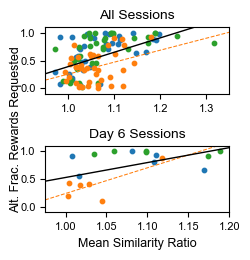

In [89]:
''' Plot Figure 2k '''
### A_ vs. REQ ALT RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sindgrid_sub,ma_sindgrid_sub,age_sindgrid_sub))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
 
#plot all session correlations
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)

ax[0].scatter(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub], color = 'C0', label = 'Young', s = 10)
ax[0].scatter(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub], color = 'C2', label = 'MA', s = 10)
ax[0].scatter(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub], color = 'C1', s = 10)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0.95,1.35])
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,0.5,1.0])
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#Select 6th sessions
sixthsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    totalsesh = len(session)
    for i, s in enumerate(session):
        if (i == (totalsesh - 1)) & (totalsesh >= 6):
            sixthsesh = np.append(sixthsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind6th = np.intersect1d(y_sindgrid_sub, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindgrid_sub, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindgrid_sub, sixthsesh).astype(int)

#day 6 data
### ALT Stability vs. REQ RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sind6th],reqalt_rates[y_sind6th])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sind6th],reqalt_rates[ma_sind6th])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sind6th],reqalt_rates[age_sind6th])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th,ma_sind6th,age_sind6th))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sAB_ratio[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 10)
ax[1].scatter(sAB_ratio[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 10)
ax[1].scatter(sAB_ratio[age_sind6th],reqalt_rates[age_sind6th], color = 'C1', s = 10)
#ax[1].set_xlabel('Avg. Stability in A_ & B_')
#ax[1].set_ylabel('Fraction Rewards Requested')
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0.975,1.2])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].set_xlabel('Mean Similarity Ratio', fontsize = 9)
#ax[1].plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', label = 'Young Fit')
#ax[1].plot(X_plot, maslope1*X_plot + maint1, '--', color = 'C2', label = 'MA Fit')
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + '2K.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2K.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2819098716114151 0.44975468866069823 0.5719928588345101 0.407733990717708
P [Young, MA, Aged, All]: 
0.0408469763298259 0.000448258985355836 7.666811942748772e-06 6.584353053540282e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.49435556119258633 0.5103690037576075 0.39764618131342777 0.4616641274856602
P [Young, MA, Aged, All]: 
0.00016831333234685502 4.9955054705918986e-05 0.0031930175239869847 5.54894184290362e-10

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4671311137086436 0.479417794882366 0.6747041630750541 0.5146742481089026
P [Young, MA, Aged, All]: 
4.4664066823195915e-07 6.794882070679685e-08 2.1966204385492545e-15 1.9067582185736598e-23

n session halves: young, ma, aged
106 114 106


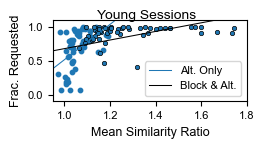

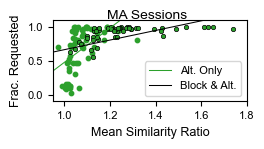

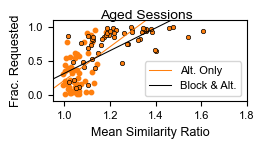

In [32]:
''' Plot Alternative Figure 2I with Block Data '''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2I_alt1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2I_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + '2I_alt2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2I_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + '2I_alt3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '2I_alt3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3456508346122626 0.3796679605740946 0.4583486469811562 0.407733990717708
P [Young, MA, Aged, All]: 
0.038938063586197634 0.022378471476769607 0.005622021422983838 6.584353053540282e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5141130518770898 0.5175329296391047 0.35579157195757666 0.4616641274856602
P [Young, MA, Aged, All]: 
0.0013390748424113729 0.0012271231150972441 0.035937321184630985 5.54894184290362e-10

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4998454306143438 0.45130766795996347 0.6426460669968581 0.5097913587012983
P [Young, MA, Aged, All]: 
7.81116263552498e-06 6.924519621449157e-05 2.0023622272744125e-09 1.4819864166360915e-15

n session halves: young, ma, aged
72 72 70


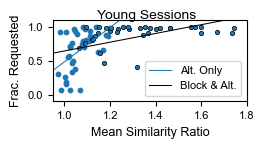

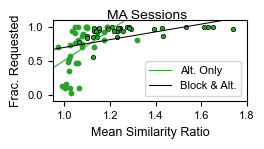

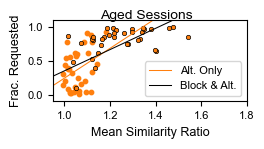

In [50]:
#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid_sub],sAB_ratio[y_sindgrid_sub])),np.hstack((reqblock_rates[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid_sub],sAB_ratio[ma_sindgrid_sub])),np.hstack((reqblock_rates[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid_sub],sAB_ratio[age_sindgrid_sub])),np.hstack((reqblock_rates[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid_sub, ma_sindgrid_sub, age_sindgrid_sub))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid_sub)*2,len(ma_sindgrid_sub)*2,len(age_sindgrid_sub)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid_sub],reqalt_rates[y_sindgrid_sub], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid_sub],reqblock_rates[y_sindgrid_sub], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + '2I_alt1.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2I_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid_sub],reqalt_rates[ma_sindgrid_sub], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid_sub],reqblock_rates[ma_sindgrid_sub], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + '2I_alt2.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2I_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid_sub],reqalt_rates[age_sindgrid_sub], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid_sub],reqblock_rates[age_sindgrid_sub], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
#plt.savefig(save_folder + '2I_alt3.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2I_alt3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [33]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.spearmanr(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(sABratio[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(sAB_ratio[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.40414563961978905 0.6592673433906859 0.6327720757362129 0.5534022903157251
P [Young, MA, Aged, All]: 
0.0026888438196728697 2.456877515172092e-08 3.7043188865453474e-07 1.843338681277753e-14

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5594724867998051 0.6176610274297656 0.24262351066192347 0.5027412629559326
P [Young, MA, Aged, All]: 
1.330514278204727e-05 3.0844247700864986e-07 0.08003776241070455 7.998705125335838e-12

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.6652427786267866 0.6848789005730258 0.7261142700843628 0.6883393227743266
P [Young, MA, Aged, All]: 
7.364972845097045e-15 4.356338855120138e-17 1.2852840237348077e-18 4.2857370306222495e-47



Association btwn Alt., Block, & BLock + Alt. Change in Performance & ratioility:
R [Block, Alt. & BLock + Alt.]: 
0.7760852516403245 0.3136214968846238 0.1865320109301324
P [Block, Alt. & BLock + Alt.]: 
0.0002498806512838071 0.22026560078064858 0.2908394586305677


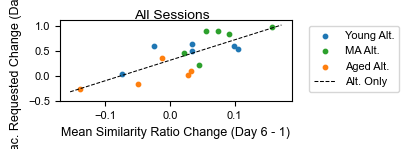

12
12
10


In [52]:
''' Plot Alternative Figure 2g with Block Data as Change between Day 6 vs. Day 1 '''

#Select 6th sessions and 1st sessions for those mice
sixthsesh = []
firstsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    
    totalsesh = len(session)
    firstcount = seshcount
    
    for i, s in enumerate(session):
        
        if (seshcount in allidx) & (firstcount in allidx):
            includeflag = True
        else: 
            includeflag = False
        
        if (i == (totalsesh - 1)) & (totalsesh >= 6) & (includeflag == True):
            sixthsesh = np.append(sixthsesh, seshcount)
            firstsesh = np.append(firstsesh, firstcount)
            
        seshcount += 1
        
# Get indices for sixth sesssions in each age group
y_sind6th = np.intersect1d(y_sindgrid, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindgrid, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindgrid, sixthsesh).astype(int)

y_sind1st = np.intersect1d(y_sindgrid, firstsesh).astype(int)
ma_sind1st = np.intersect1d(ma_sindgrid, firstsesh).astype(int)
age_sind1st = np.intersect1d(age_sindgrid, firstsesh).astype(int)

#calculate change in block & alt ratio for each mouse by age group (Day 6 - Day 1)
y_deltaltratio = sAB_ratio[y_sind6th] - sAB_ratio[y_sind1st]
ma_deltaltratio = sAB_ratio[ma_sind6th] - sAB_ratio[ma_sind1st]
age_deltaltratio = sAB_ratio[age_sind6th] - sAB_ratio[age_sind1st]

y_deltblockratio = sABratio[y_sind6th] - sABratio[y_sind1st]
ma_deltblockratio = sABratio[ma_sind6th] - sABratio[ma_sind1st]
age_deltblockratio = sABratio[age_sind6th] - sABratio[age_sind1st]

#calculate change in block & alt requests for each mouse by age group (Day 6 - Day 1)
y_deltaltreq = reqalt_rates[y_sind6th] - reqalt_rates[y_sind1st]
ma_deltaltreq = reqalt_rates[ma_sind6th] - reqalt_rates[ma_sind1st]
age_deltaltreq = reqalt_rates[age_sind6th] - reqalt_rates[age_sind1st]

y_deltblockreq = reqblock_rates[y_sind6th] - reqblock_rates[y_sind1st]
ma_deltblockreq = reqblock_rates[ma_sind6th] - reqblock_rates[ma_sind1st]
age_deltblockreq = reqblock_rates[age_sind6th] - reqblock_rates[age_sind1st]

all_deltblockratio = np.concatenate((y_deltblockratio,ma_deltblockratio,age_deltblockratio))
all_deltaltratio = np.concatenate((y_deltaltratio,ma_deltaltratio,age_deltaltratio))
all_deltblockreq = np.concatenate((y_deltblockreq,ma_deltblockreq,age_deltblockreq))
all_deltaltreq = np.concatenate((y_deltaltreq,ma_deltaltreq,age_deltaltreq))

#Linear regression with alt data only
res = stats.linregress(all_deltaltratio,all_deltaltreq)
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue ; allp1 = res.pvalue

#Linear regression with block data only
res = stats.linregress(all_deltblockratio,all_deltblockreq)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue ; allp2 = res.pvalue

#Linear regression with block data only
res = stats.linregress(np.hstack((all_deltblockratio,all_deltaltratio)),np.hstack((all_deltblockreq,all_deltaltreq)))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue ; allp3 = res.pvalue

print('\nAssociation btwn Alt., Block, & BLock + Alt. Change in Performance & ratioility:')
print('R [Block, Alt. & BLock + Alt.]: ')
print(allr1, allr2, allr3)
print('P [Block, Alt. & BLock + Alt.]: ')
print(allp1, allp2, allp3)

#Plot ratioility over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (3,1.05))
fig.suptitle('All Sessions', fontsize = 10)
ax.scatter(y_deltaltratio,y_deltaltreq, color = 'C0', s = 10, label = 'Young Alt.')
#ax.scatter(y_deltblockratio,y_deltblockreq, color = 'C0', s = 10, edgecolor = 'k', lw = 0.5, label = 'Young Block')
ax.scatter(ma_deltaltratio,ma_deltaltreq, color = 'C2', s = 10, label = 'MA Alt.')
#ax.scatter(ma_deltblockratio,ma_deltblockreq, color = 'C2', s = 10, edgecolor = 'k', lw = 0.5, label = 'MA Block')
ax.scatter(age_deltaltratio,age_deltaltreq, color = 'C1', s = 10, label = 'Aged Alt.')
#ax.scatter(age_deltblockratio,age_deltblockreq, color = 'C1', s = 10, edgecolor = 'k', lw = 0.5, label = 'Aged Block')
ax.set_xlabel('Mean Similarity Ratio Change (Day 6 - 1)', fontsize = 9)
ax.set_ylabel('Frac. Requested Change (Day 6 - 1)', fontsize = 9)
ax.set_ylim([-0.5,1.1])
ax.set_yticks([-0.5,0,0.5,1.0])
#ax.set_xlim([-0.4,0.4])
#ax.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-.', color = 'k', linewidth = 0.75, label = 'Block Only')
#ax.plot(X_plot, allslope3*X_plot + allint3, '-', color = 'k', linewidth = 0.75, label = 'Block + Alt.')
ax.legend(fontsize = 8,bbox_to_anchor = (1.05,1.0), ncol = 1)
#plt.savefig(save_folder + '2I_alt.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + '2I_alt.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

print(len(y_deltaltratio) + len(y_deltblockratio))
print(len(ma_deltaltratio) + len(ma_deltblockratio))
print(len(age_deltaltratio) + len(age_deltblockratio))

In [76]:
''' Examine Reward Zone Over-Representation in Grid Cells (Reviewer Figure 4)

For both grid & NGS cells, across age groups: 
a. Find reward zone FR on each trial, normalized to peak / min FR by trial for each cell. 
b. Then, calculate fold change in norm rzFR (post - pre) in each session during block trials (akin to learning)
- Mean "pre learning" rzFR (first 5 trials / context) during block
- Mean "post learning" rzFR (last 5 trials / context) during block
c. Also, calculate mean block reward zone FR & mean alt. reward zone FR. 


'''
#cell arrays
alldFR_grid = []
alldFR_ngs = []
allpre_grid = []
allpre_ngs = []
allpost_grid = []
allpost_ngs = []
allblock_grid = []
allblock_ngs = []
allalt_grid = []
allalt_ngs = []

#session arrays
sdFR_grid = []
sdFR_ngs = []
spre_grid = []
spre_ngs = []
spost_grid = []
spost_ngs = []
sblock_grid = []
sblock_ngs = []
salt_grid = []
salt_ngs = []

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
                
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #calculate normalized FR, sorting alt trials by context, trimming dark & end frames
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
        else:
            end_idx = len(skippedrawtrialfil) + 1
        FR, binnedpos, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        
        #normalize FR to peak FR BY TRIAL for each cell
        #for c in range(FR.shape[2]):
            #for t in range(FR.shape[0]):
                #FR[t, :, c] = (FR[t, :, c] - np.min(FR[t, :, c]))/np.max(FR[t, :, c] - np.min(FR[t, :, c]))
        
        #find boolean mask indices of reward zones position bins on Context A/B trials 
        aidx = np.where((binnedpos > (centera - 25)) & (binnedpos <= (centera + 25)))
        maska = np.zeros(len(binnedpos), bool)
        maska[aidx] = 1
        
        bidx = np.where((binnedpos > (centerb - 25)) & (binnedpos <= (centerb + 25)))
        maskb = np.zeros(len(binnedpos), bool)
        maskb[bidx] = 1
        
        #load indices of observations by VR trial block, excluding A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))

        #find reward zone centers 
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # analyze grid cell reward zone firing 
        grid_meanpre = []
        grid_meanpost = []
        grid_dFR = [] # abs % difference in mean reward zone FR (post - pre) 
        grid_meanblock = []
        grid_meanalt = []
        
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int) 
            cellFR = FR[:,:,sdx]
                
            # find normalized reward zone FR by trial
            Blockpre = [] # reward zone FR in first 10 block trials (5 first trials / context)
            Blockpost = [] # reward zone FR in first 10 block trials (5 last trials / context)
            BlockrzFR = [] #reward zone FR for all block trials
            AltrzFR = [] #reward zone FR for all alt trials
            
            for t in range(cellFR.shape[0]):
                
                if (t < lengthA): # block A rewards 
                    rzFR = np.mean(cellFR[t,maska])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < 5:
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= (lengthA - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                        
                    #print(str(c) + ' Block A, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= lengthA) & (t < (lengthA + lengthB)): # block B rewards
                    rzFR = np.mean(cellFR[t,maskb])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < (5 + lengthA):
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= ((lengthA + lengthB) - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                    
                    #print(str(c) + ' Block B, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB)) & (t < (lengthA + lengthB + lengthA_)): #block A` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maska])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    #print(str(c) + ' Block A`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB + lengtha_)) & (t < (lengthA + lengthB + lengtha_ + lengthB_)): # block B` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maskb])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    
                    #print(str(c) + ' Block B`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
            
            # save out mean pre, post, % diff post-pre reward zone FR, mean block, mean alt firing by cell 
            grid_meanpre = np.append(grid_meanpre, np.mean(Blockpre))
            grid_meanpost = np.append(grid_meanpost, np.mean(Blockpost))
            grid_meanblock = np.append(grid_meanblock, np.mean(BlockrzFR))
            grid_meanalt = np.append(grid_meanalt, np.mean(AltrzFR))
            grid_dFR = np.append(grid_dFR, (np.mean(Blockpost) - np.mean(Blockpre)) / ((np.mean(Blockpost) + np.mean(Blockpre))/2)*100)
        
        # analyze ngs cell reward zone firing         
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell] 
        
        ngs_meanpre = []
        ngs_meanpost = []
        ngs_dFR = [] # abs % difference in mean reward zone FR (post - pre) 
        ngs_meanblock = []
        ngs_meanalt = []

        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int) 
            cellFR = FR[:,:,sdx]
                
            # find normalized reward zone FR by trial
            Blockpre = [] # reward zone FR in first 10 block trials (5 first trials / context)
            Blockpost = [] # reward zone FR in first 10 block trials (5 last trials / context)
            BlockrzFR = [] #reward zone FR for all block trials
            AltrzFR = [] #reward zone FR for all alt trials
            
            for t in range(cellFR.shape[0]):
                
                if (t < lengthA): # block A rewards 
                    rzFR = np.mean(cellFR[t,maska])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < 5:
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= (lengthA - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                        
                    #print(str(c) + ' Block A, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= lengthA) & (t < (lengthA + lengthB)): # block B rewards
                    rzFR = np.mean(cellFR[t,maskb])
                    BlockrzFR = np.append(BlockrzFR, rzFR)
                    
                    if t < (5 + lengthA):
                        Blockpre = np.append(Blockpre, rzFR)
                    
                    if (t >= ((lengthA + lengthB) - 5)):
                        Blockpost = np.append(Blockpost, rzFR)
                    
                    #print(str(c) + ' Block B, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB)) & (t < (lengthA + lengthB + lengthA_)): #block A` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maska])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    #print(str(c) + ' Block A`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
                elif (t >= (lengthA + lengthB + lengtha_)) & (t < (lengthA + lengthB + lengtha_ + lengthB_)): # block B` rewards excl. gain change
                    rzFR = np.mean(cellFR[t,maskb])
                    AltrzFR = np.append(AltrzFR, rzFR)
                    
                    #print(str(c) + ' Block B`, Total VR Trial ' + str(t) + ', FR = ' + str(np.round(rzFR, 2)))
            
            # save out mean pre, post, % diff post-pre reward zone FR, mean block, mean alt firing by cell 
            ngs_meanpre = np.append(ngs_meanpre, np.mean(Blockpre))
            ngs_meanpost = np.append(ngs_meanpost, np.mean(Blockpost))
            ngs_meanblock = np.append(ngs_meanblock, np.mean(BlockrzFR))
            ngs_meanalt = np.append(ngs_meanalt, np.mean(AltrzFR))
            ngs_dFR = np.append(ngs_dFR, (np.mean(Blockpost) - np.mean(Blockpre)) / ((np.mean(Blockpost) + np.mean(Blockpre))/2)*100)
                                                           
        #save out cell & session data for grid cells
        alldFR_grid = np.append(alldFR_grid, grid_dFR)
        alldFR_ngs = np.append(alldFR_ngs, ngs_dFR)
        allpre_grid = np.append(allpre_grid, grid_meanpre)
        allpre_ngs = np.append(allpre_ngs,ngs_meanpre)
        allpost_grid = np.append(allpost_grid, grid_meanpost)
        allpost_ngs = np.append(allpost_ngs, ngs_meanpost)
        allblock_grid = np.append(allblock_grid, grid_meanblock)
        allblock_ngs = np.append(allblock_ngs, ngs_meanblock)
        allalt_grid = np.append(allalt_grid, grid_meanalt)
        allalt_ngs = np.append(allalt_ngs, ngs_meanalt)

        #session arrays
        sdFR_grid = np.append(sdFR_grid, np.mean(grid_dFR))
        sdFR_ngs = np.append(sdFR_ngs, np.mean(ngs_dFR))
        spre_grid = np.append(spre_grid, np.mean(grid_meanpre))
        spre_ngs = np.append(spre_ngs, np.mean(ngs_meanpre))
        spost_grid = np.append(spost_grid, np.mean(grid_meanpost))
        spost_ngs = np.append(spost_ngs, np.mean(ngs_meanpost))
        sblock_grid = np.append(sblock_grid, np.mean(grid_meanblock))
        sblock_ngs = np.append(sblock_ngs, np.mean(ngs_meanalt))
        salt_grid = np.append(salt_grid, np.mean(grid_meanalt))
        salt_ngs = np.append(salt_ngs, np.mean(ngs_meanalt))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [193]:
'''Statistically Compare (across Age Groups at Cell Level) Block & Alt RZ FR'''

#AGE GROUP DIFFERENCES WITHIN CELL TYPE
# grid rz firing rate (block)
print('\nGRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allblock_grid[ygridcells], allblock_grid[magridcells], allblock_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(allblock_grid[ygridcells], allblock_grid[magridcells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(allblock_grid[ygridcells], allblock_grid[agedgridcells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(allblock_grid[agedgridcells], allblock_grid[magridcells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# grid rz firing rate (alt)
print('\nGRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allalt_grid[ygridcells], allalt_grid[magridcells], allalt_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(allalt_grid[ygridcells], allalt_grid[magridcells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(allalt_grid[ygridcells], allalt_grid[agedgridcells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(allalt_grid[agedgridcells], allalt_grid[magridcells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# ngs rz firing rate (block)
print('\nngs CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allblock_ngs[yngscells], allblock_ngs[mangscells], allblock_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(allblock_ngs[yngscells], allblock_ngs[mangscells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(allblock_ngs[yngscells], allblock_ngs[agedngscells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(allblock_ngs[agedngscells], allblock_ngs[mangscells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# ngs rz firing rate (alt)
print('\nngs CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(allalt_ngs[yngscells], allalt_ngs[mangscells], allalt_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(allalt_ngs[yngscells], allalt_ngs[mangscells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(allalt_ngs[yngscells], allalt_ngs[agedngscells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(allalt_ngs[agedngscells], allalt_ngs[mangscells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

#STATS on block FR (MEAN ± SEM) for GRID CELLS
print('\nGRID CELL Block INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allblock_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[ygridcells]),3)))
print(str(np.round(np.mean(allblock_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[magridcells]),3)))
print(str(np.round(np.mean(allblock_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_grid[agedgridcells]),3)))

print('\nNGS CELL Block INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allblock_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[yngscells]),3)))
print(str(np.round(np.mean(allblock_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[mangscells]),3)))
print(str(np.round(np.mean(allblock_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(allblock_ngs[agedngscells]),3)))

print('\nGRID CELL Alt INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allalt_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[ygridcells]),3)))
print(str(np.round(np.mean(allalt_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[magridcells]),3)))
print(str(np.round(np.mean(allalt_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_grid[agedgridcells]),3)))

print('\nNGS CELL Alt INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(allalt_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[yngscells]),3)))
print(str(np.round(np.mean(allalt_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[mangscells]),3)))
print(str(np.round(np.mean(allalt_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(allalt_ngs[agedngscells]),3)))


GRID CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 5.779
rate remapping (Kruskal): p = 0.05561
young vs. MA (rank sums): p = 0.01644
young vs. aged (rank sums): p = 0.2449
aged vs. MA (rank sums): p = 0.2326

GRID CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 4.101
rate remapping (Kruskal): p = 0.1286
young vs. MA (rank sums): p = 0.9171
young vs. aged (rank sums): p = 0.08064
aged vs. MA (rank sums): p = 0.07391

ngs CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 4.036
rate remapping (Kruskal): p = 0.1329
young vs. MA (rank sums): p = 0.1871
young vs. aged (rank sums): p = 0.04788
aged vs. MA (rank sums): p = 0.4843

ngs CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 24.75
rate remapping (Kruskal): p = 4.221e-06
young vs. MA (rank sums): p = 0.004149
young vs. aged (rank sums): p = 8.508e-07
aged vs. MA (rank sums): p = 0.02156

GRID CELL Block INFO:
young mean ± SEM, MA mean ± SEM, aged mean ± SEM: 
0.102 ± 0.001
0.099 ± 0.002
0.1 ± 0.002

NGS CELL Block IN

In [183]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
            
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRblock
No. Observations:       6508        Method:                 ML       
No. Groups:             29          Scale:                  0.0008   
Min. group size:        60          Log-Likelihood:         8162.1573
Max. group size:        446         Converged:              No       
Mean group size:        224.4                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.100    0.015  6.560 0.000  0.070  0.130
C(AgeGroup)[T.2.0]          0.009    0.023  0.408 0.683 -0.036  0.055
C(AgeGroup)[T.3.0]         -0.012    0.018 -0.668 0.504 -0.048  0.024
C(Sex)[T.M]                -0.004    0.024 -0.165 0.869 -0.052  0.044
C(Cohort)[T.D]              0.003   

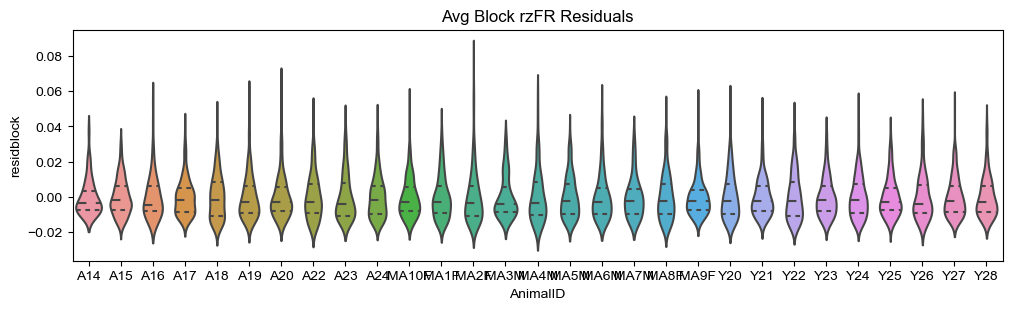

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRalt  
No. Observations:       6508        Method:                 REML     
No. Groups:             29          Scale:                  0.0014   
Min. group size:        60          Log-Likelihood:         8673.5938
Max. group size:        446         Converged:              Yes      
Mean group size:        224.4                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.085    0.005 18.716 0.000  0.076  0.094
C(AgeGroup)[T.2.0]          0.014    0.007  2.028 0.043  0.000  0.027
C(AgeGroup)[T.3.0]          0.001    0.006  0.100 0.920 -0.012  0.013
C(Sex)[T.M]                 0.003    0.006  0.426 0.670 -0.010  0.015
C(Cohort)[T.D]             -0.001   

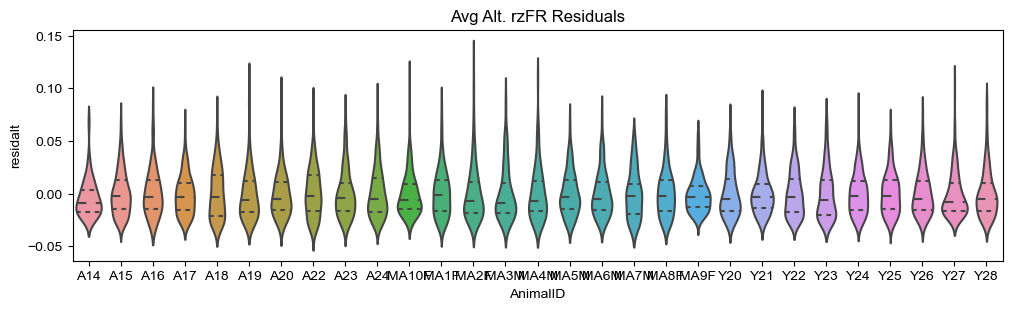

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      deltaFR    
No. Observations:      6508         Method:                  REML       
No. Groups:            29           Scale:                   1441.7951  
Min. group size:       60           Log-Likelihood:          -36524.1825
Max. group size:       446          Converged:               Yes        
Mean group size:       224.4                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -4.840    3.756 -1.289 0.198 -12.203  2.522
C(AgeGroup)[T.2.0]            1.652    5.610  0.294 0.768  -9.343 12.648
C(AgeGroup)[T.3.0]           -1.035    5.507 -0.188 0.851 -11.829  9.758
C(Sex)[T.M]                   7.147    4.550  1.571 0.116  -1.771 16.

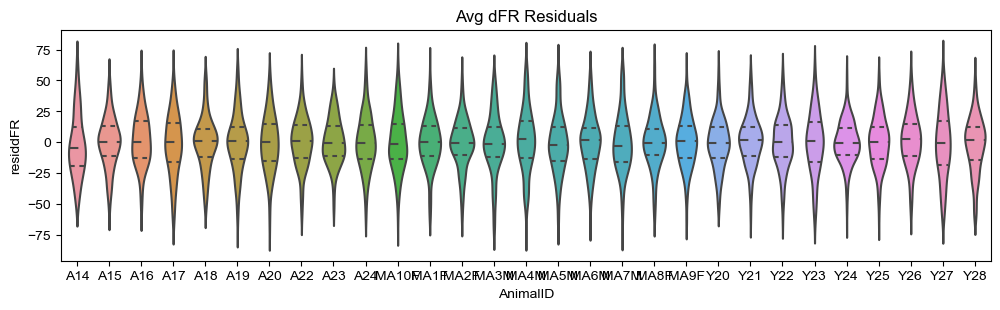

In [184]:
''' LMMs for Grid Reward Zone FR '''        
#gather dependent variables into lists
rzFRblock = list(allblock_grid)
rzFRalt = list(allalt_grid)
deltaFR = list(alldFR_grid)
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, rzFRblock,rzFRalt,deltaFR))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','rzFRblock','rzFRalt','deltaFR'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('rzFRblock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block rzFR Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('rzFRalt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. rzFR Residuals')
plt.show()

#Delta Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdFR = smf.mixedlm('deltaFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mdFR.summary())
print(mdFR.wald_test_terms(scalar = False))

df['residdFR'] = mdFR.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residdFR', inner = 'quartile', ax = ax)
plt.title('Avg dFR Residuals')
plt.show()


In [185]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

srzFRAfitted_seg_aged = [[] * r for i in range(r)]
srzFRAfitted_seg_MA = [[] * r for i in range(r)]
srzFRAfitted_seg_young = [[] * r for i in range(r)]
srzFRBfitted_seg_aged = [[] * r for i in range(r)]
srzFRBfitted_seg_MA = [[] * r for i in range(r)]
srzFRBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_aged[idx] = np.append(srzFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            srzFRBfitted_seg_aged[idx] = np.append(srzFRBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_MA[idx] = np.append(srzFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_MA[idx] = np.append(srzFRBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_young[idx] = np.append(srzFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_young[idx] = np.append(srzFRBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


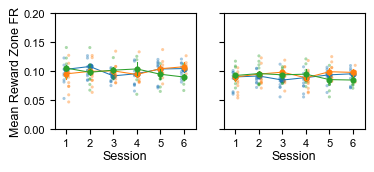

In [186]:
''' Composite Plot of Block & Alt. RZ FR w/ Fitted Session Average Data Points (Reviewer Figure 4C)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.05,0.1,0.15,0.2])
ax[0].set_ylim([0,0.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Reward Zone FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.05,0.1,0.15,0.2])
ax[1].set_ylim([0,0.2])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(srzFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, srzFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], srzFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, srzFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, srzFRBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], srzFRBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, srzFRBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure4A.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure4A.svg', dpi=400, bbox_inches='tight')
plt.show()

In [187]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mdFRfitted'] = mdFR.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mdFRfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mdFRfitted'])

sdFRAfitted_seg_aged = [[] * r for i in range(r)]
sdFRAfitted_seg_MA = [[] * r for i in range(r)]
sdFRAfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_aged[idx] = np.append(sdFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_MA[idx] = np.append(sdFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
        
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_young[idx] = np.append(sdFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)


n aged, MA, young mice on day 1
10 10 8

n aged, MA, young mice on day 2
10 10 9

n aged, MA, young mice on day 3
9 10 9

n aged, MA, young mice on day 4
9 9 9

n aged, MA, young mice on day 5
8 9 9

n aged, MA, young mice on day 6
7 9 9


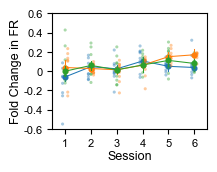

In [188]:
''' Composite Plot of Block & Alt. d FR w/ Fitted Session Average Data Points (Reviewer Figure 4C)'''
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mdFR.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([-60,-40,-20,0,20,40,60])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_ylim([-60,60])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
#scatter plot LMM-fitted session average data:
for i in range(0,len(sdFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    ax.scatter(sessionAcountfitted_aged[i] + 0.1, sdFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_MA[i], sdFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_young[i] - 0.1, sdFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure4F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure4F.svg', dpi=400, bbox_inches='tight')
plt.show()

In [149]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
            
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRblock
No. Observations:       6559        Method:                 REML     
No. Groups:             29          Scale:                  0.0021   
Min. group size:        65          Log-Likelihood:         6646.0458
Max. group size:        446         Converged:              Yes      
Mean group size:        226.2                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.112    0.006 19.671 0.000  0.101  0.123
C(AgeGroup)[T.2.0]          0.019    0.008  2.339 0.019  0.003  0.035
C(AgeGroup)[T.3.0]          0.006    0.008  0.778 0.437 -0.009  0.021
C(Sex)[T.M]                 0.005    0.007  0.796 0.426 -0.008  0.019
C(Cohort)[T.D]             -0.004   

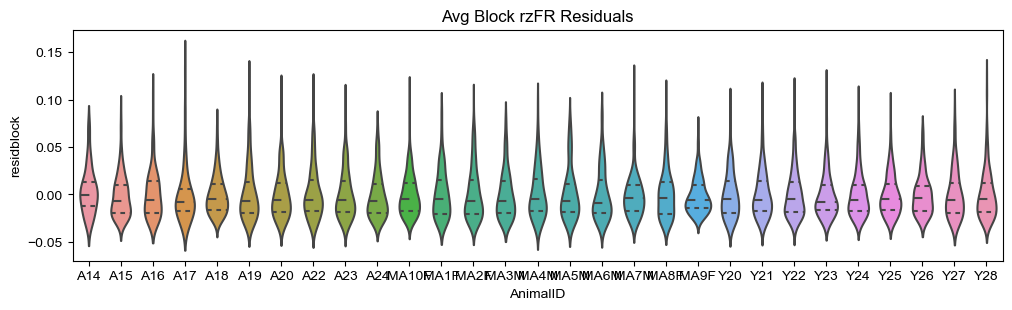

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     rzFRalt  
No. Observations:       6559        Method:                 REML     
No. Groups:             29          Scale:                  0.0021   
Min. group size:        65          Log-Likelihood:         7294.1980
Max. group size:        446         Converged:              Yes      
Mean group size:        226.2                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.096    0.006 17.442 0.000  0.086  0.107
C(AgeGroup)[T.2.0]          0.018    0.008  2.311 0.021  0.003  0.034
C(AgeGroup)[T.3.0]          0.026    0.007  3.518 0.000  0.011  0.040
C(Sex)[T.M]                 0.008    0.007  1.173 0.241 -0.005  0.022
C(Cohort)[T.D]             -0.007   

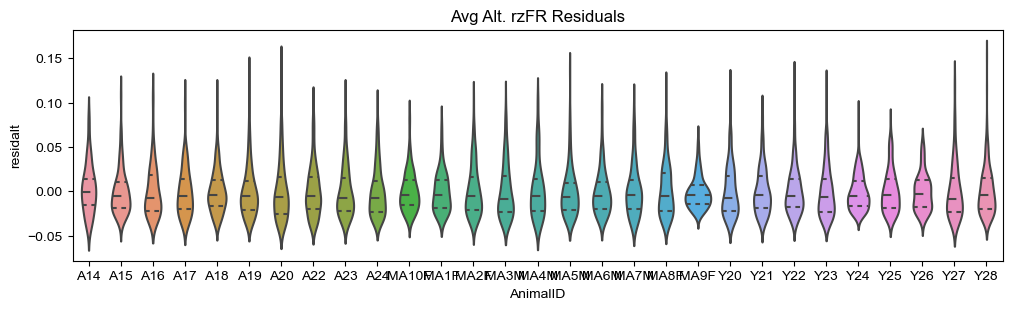

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      deltaFR    
No. Observations:      6559         Method:                  REML       
No. Groups:            29           Scale:                   1259.0000  
Min. group size:       65           Log-Likelihood:          -36390.2800
Max. group size:       446          Converged:               Yes        
Mean group size:       226.2                                            
------------------------------------------------------------------------
                            Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -4.894    3.605 -1.357 0.175 -11.960  2.172
C(AgeGroup)[T.2.0]            8.365    5.101  1.640 0.101  -1.634 18.364
C(AgeGroup)[T.3.0]           12.230    5.032  2.431 0.015   2.368 22.093
C(Sex)[T.M]                  -0.279    3.842 -0.073 0.942  -7.809  7.

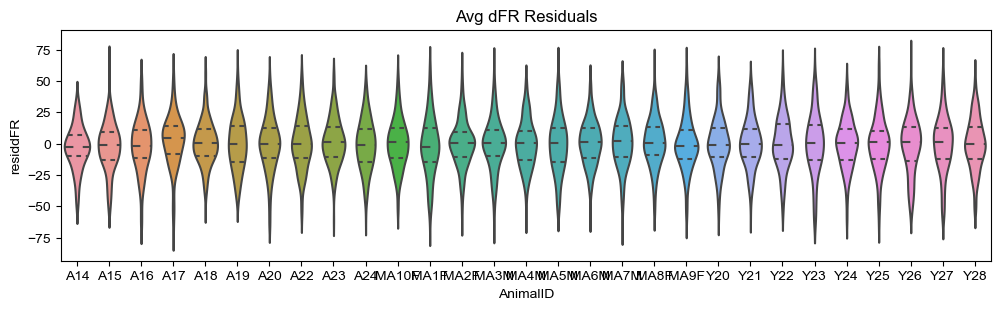

In [150]:
''' LMMs for NGS Reward Zone FR '''        
#gather dependent variables into lists
rzFRblock = list(allblock_ngs)
rzFRalt = list(allalt_ngs)
deltaFR = list(alldFR_ngs)
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, rzFRblock,rzFRalt,deltaFR))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','rzFRblock','rzFRalt','deltaFR'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('rzFRblock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block rzFR Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('rzFRalt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. rzFR Residuals')
plt.show()

#Delta Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdFR = smf.mixedlm('deltaFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mdFR.summary())
print(mdFR.wald_test_terms(scalar = False))

df['residdFR'] = mdFR.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residdFR', inner = 'quartile', ax = ax)
plt.title('Avg dFR Residuals')
plt.show()



In [151]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

srzFRAfitted_seg_aged = [[] * r for i in range(r)]
srzFRAfitted_seg_MA = [[] * r for i in range(r)]
srzFRAfitted_seg_young = [[] * r for i in range(r)]
srzFRBfitted_seg_aged = [[] * r for i in range(r)]
srzFRBfitted_seg_MA = [[] * r for i in range(r)]
srzFRBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_aged[idx] = np.append(srzFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            srzFRBfitted_seg_aged[idx] = np.append(srzFRBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_MA[idx] = np.append(srzFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_MA[idx] = np.append(srzFRBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            srzFRAfitted_seg_young[idx] = np.append(srzFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            srzFRBfitted_seg_young[idx] = np.append(srzFRBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


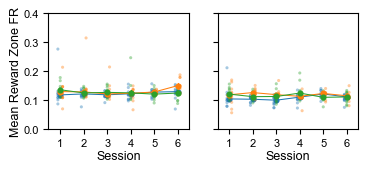

In [152]:
''' Composite Plot of Block & Alt RZ FR w/ Fitted Session Average Data Points (Reviewer Figure 4D)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_ylim([0,0.4])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Reward Zone FR', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_ylim([0,0.4])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(srzFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, srzFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], srzFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, srzFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, srzFRBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], srzFRBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, srzFRBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure4B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure4B.svg', dpi=400, bbox_inches='tight')
plt.show()

In [153]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mdFRfitted'] = mdFR.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mdFRfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mdFRfitted'])

sdFRAfitted_seg_aged = [[] * r for i in range(r)]
sdFRAfitted_seg_MA = [[] * r for i in range(r)]
sdFRAfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_aged[idx] = np.append(sdFRAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_MA[idx] = np.append(sdFRAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
        
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            sdFRAfitted_seg_young[idx] = np.append(sdFRAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)


n aged, MA, young mice on day 1
10 10 9

n aged, MA, young mice on day 2
10 10 9

n aged, MA, young mice on day 3
10 10 9

n aged, MA, young mice on day 4
9 10 9

n aged, MA, young mice on day 5
8 9 9

n aged, MA, young mice on day 6
8 9 9


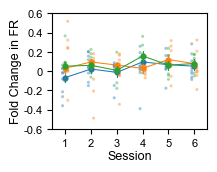

In [154]:
''' Plot of NGS dFR w/ Fitted Session Average Data Points (Reviewer Figure 4G)'''
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mdFR.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_yticks([-60,-40,-20,0,20,40,60])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_ylim([-60,60])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
#scatter plot LMM-fitted session average data:
for i in range(0,len(sdFRAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    ax.scatter(sessionAcountfitted_aged[i] + 0.1, sdFRAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_MA[i], sdFRAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcountfitted_young[i] - 0.1, sdFRAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure4G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure4G.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.07834792780822265 -0.06466300404934297 0.162772892485785 0.07702140353185695
P [Young, MA, Aged, All]: 
0.5770909312995105 0.632735713333964 0.2442076958877931 0.32845615266886463

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.053868277539062495 0.031010373853468477 0.156596480569485 0.020498221800288458
P [Young, MA, Aged, All]: 
0.7016500493252112 0.8188756708380152 0.26280733542921475 0.7950820625991413

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.12386794178351161 0.08996067974304227 0.22783714502622812 0.13430377566826257
P [Young, MA, Aged, All]: 
0.2058514066878647 0.34116622799146146 0.018829169950501247 0.015240763805607618

n session halves: young, ma, aged
106 114 106


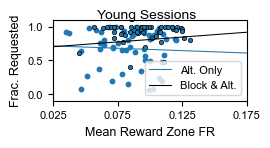

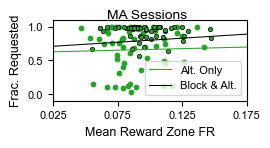

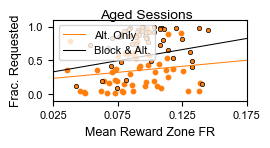

In [155]:
''' Plot Reviewer Figure 4E with Block & Alt. RZ FR Data for Grid Cells'''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(sblock_grid[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sblock_grid[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sblock_grid[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sblock_grid[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(salt_grid[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(salt_grid[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(salt_grid[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(salt_grid[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sblock_grid[y_sindgrid],salt_grid[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[ma_sindgrid],salt_grid[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[age_sindgrid],salt_grid[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sblock_grid[allidx],salt_grid[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(salt_grid[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sblock_grid[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4C_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4C_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(salt_grid[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sblock_grid[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4C_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4C_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(salt_grid[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sblock_grid[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.025,0.175])
ax.set_xticks([0.025,0.075,0.125,0.175])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure4C_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4C_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.07148775294243395 -0.025803046227142912 -0.08514918389020237 -0.07856642208066968
P [Young, MA, Aged, All]: 
0.607467643301558 0.8475351645607675 0.536507465044517 0.31286095556833327

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.13696130111384505 -0.06424539658551744 0.02244753064612264 -0.07986443743765684
P [Young, MA, Aged, All]: 
0.3233633693884518 0.6318512240067071 0.8707766728191507 0.3049085683094419

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.09480866828740477 -0.042654860994136644 -0.022960768667215335 -0.06634051838519552
P [Young, MA, Aged, All]: 
0.3290563564509208 0.6493691841218816 0.8118074019686822 0.2265843343628353

n session halves: young, ma, aged
108 116 110


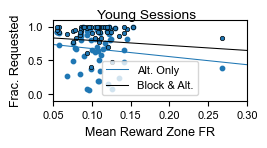

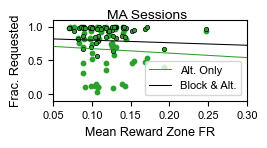

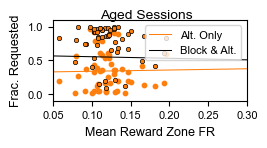

In [156]:
''' Plot Reviewer Figure 4F with Block & Alt. RZ FR Data for NGS Cells'''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sblock_ngs[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sblock_ngs[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sblock_ngs[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sblock_ngs[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(salt_ngs[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(salt_ngs[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(salt_ngs[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(salt_ngs[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sblock_ngs[y_sindngs],salt_ngs[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[ma_sindngs],salt_ngs[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[age_sindngs],salt_ngs[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sblock_ngs[allidx],salt_ngs[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(salt_ngs[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sblock_ngs[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4D_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4D_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(salt_ngs[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sblock_ngs[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4D_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4D_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(salt_ngs[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sblock_ngs[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.05,0.3])
ax.set_xticks([0.05,0.10,0.15,0.2,0.25,0.3])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4D_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4D_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [157]:
''' Index Young, MA, & Aged Cells '''

#Find number of young, MA, aged cells of each type
ygridcells = np.zeros(len(alldFR_grid),bool)
magridcells = np.zeros(len(alldFR_grid),bool)
agedgridcells = np.zeros(len(alldFR_grid),bool)

yngscells = np.zeros(len(alldFR_ngs),bool)
mangscells = np.zeros(len(alldFR_ngs),bool)
agedngscells = np.zeros(len(alldFR_ngs),bool)

totalgridcells = 0
totalngscells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        for k, c in enumerate(gridcells):
            
            if m in SM_aged_mice:
                agedgridcells[totalgridcells] = 1
            elif m in SM_MA_mice:
                magridcells[totalgridcells] = 1
            else:
                 ygridcells[totalgridcells] = 1      
            
            totalgridcells += 1
            
        for j, c in enumerate(ngscells):
            
            if m in SM_aged_mice:
                agedngscells[totalngscells] = 1
            elif m in SM_MA_mice:
                mangscells[totalngscells] = 1
            else:
                 yngscells[totalngscells] = 1      
            
            totalngscells += 1
            
grid_n_y = np.sum(ygridcells)
grid_n_ma = np.sum(magridcells)
grid_n_aged = np.sum(agedgridcells)

ngs_n_y = np.sum(yngscells)
ngs_n_ma = np.sum(mangscells)
ngs_n_aged = np.sum(agedngscells)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

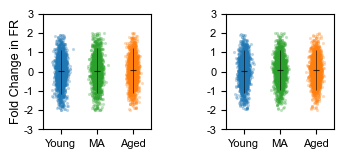

In [158]:
''' Assess if reward representation increases over spatial learning within session to different extents across age groups '''

# plotting params
gs = gridspec.GridSpec(1, 2, wspace=0.7)
f = plt.figure(figsize=(3.75, 1.5))
PLOT_COLORS = ['C0', 'C2', 'C1']
PT_SIZE = 5
PT_LW = 0
BAR_SIZE = 4
BAR_WIDTH = 0.8
LW_PCT = 0.6
SIG_SIZE = 5
LW_SIG = 0.8
POSITIONS = np.asarray([1, 3, 5])

# set jitter
JIT = 0.15
j_y = np.random.randn(grid_n_y) * JIT
j_ma = np.random.randn(grid_n_ma) * JIT
j_aged = np.random.randn(grid_n_aged) * JIT

# CHANGE IN FIRING RATE (GRID)
ax0 = plt.subplot(gs[0])
ax0.scatter(np.full(grid_n_y, POSITIONS[0])+j_y, alldFR_grid[ygridcells], s=PT_SIZE, lw=PT_LW, 
            color='C0', alpha=0.3, zorder=1)
ax0.scatter(np.full(grid_n_ma, POSITIONS[1])+j_ma, alldFR_grid[magridcells], s=PT_SIZE, lw=PT_LW, 
            color='C2', alpha=0.3, zorder=1)
ax0.scatter(np.full(grid_n_aged, POSITIONS[2])+j_aged, alldFR_grid[agedgridcells], s=PT_SIZE, lw=PT_LW, 
            color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(alldFR_grid[ygridcells]), np.median(alldFR_grid[magridcells]), np.median(alldFR_grid[agedgridcells])])
dFR_5 = np.asarray([np.percentile(alldFR_grid[ygridcells], 5), np.percentile(alldFR_grid[magridcells], 5), np.percentile(alldFR_grid[agedgridcells], 5)])
dFR_95 = np.asarray([np.percentile(alldFR_grid[ygridcells], 95), np.percentile(alldFR_grid[magridcells], 95), np.percentile(alldFR_grid[agedgridcells], 95)])
ax0.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax0.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax0.tick_params(which='major', labelsize=8)
ax0.set_xticks(POSITIONS)
ax0.set_xticklabels(['Young', 'MA', 'Aged'])
ax0.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax0.set_yticks(np.arange(-300, 310, 100))
ax0.set_yticklabels([-3,-2,-1,0,1,2,3])
ax0.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

# set jitter for NGS cells
JIT = 0.15
j_y = np.random.randn(ngs_n_y) * JIT
j_ma = np.random.randn(ngs_n_ma) * JIT
j_aged = np.random.randn(ngs_n_aged) * JIT

# CHANGE IN FIRING RATE (NGS)
ax1 = plt.subplot(gs[1])
ax1.scatter(np.full(ngs_n_y, POSITIONS[0])+j_y, alldFR_ngs[yngscells], s=PT_SIZE, lw=PT_LW, color='C0', alpha=0.3, zorder=1)
ax1.scatter(np.full(ngs_n_ma, POSITIONS[1])+j_ma, alldFR_ngs[mangscells], s=PT_SIZE, lw=PT_LW, color='C2', alpha=0.3, zorder=1)
ax1.scatter(np.full(ngs_n_aged, POSITIONS[2])+j_aged, alldFR_ngs[agedngscells], s=PT_SIZE, lw=PT_LW, color='C1', alpha=0.3, zorder=1)

# mark median and 95th percentiles
dFR_medians = np.asarray([np.median(alldFR_ngs[yngscells]), np.median(alldFR_ngs[mangscells]), np.median(alldFR_ngs[agedngscells])])
dFR_5 = np.asarray([np.percentile(alldFR_ngs[yngscells], 5), np.percentile(alldFR_ngs[mangscells], 5), np.percentile(alldFR_ngs[agedngscells], 5)])
dFR_95 = np.asarray([np.percentile(alldFR_ngs[yngscells], 95), np.percentile(alldFR_ngs[mangscells], 95), np.percentile(alldFR_ngs[agedngscells], 95)])
ax1.plot(POSITIONS[:-1], dFR_medians[:-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.plot(POSITIONS[-1], dFR_medians[-1], '_k', markersize=BAR_SIZE, markeredgewidth=BAR_WIDTH, zorder=2, alpha=0.7)
ax1.vlines(POSITIONS, dFR_5, dFR_95, lw=LW_PCT, colors=['k', 'k', 'k'], linestyles='solid', zorder=2, alpha=0.7)

# set axis params
ax1.tick_params(which='major', labelsize=8)
ax1.set_xticks(POSITIONS)
ax1.set_xticklabels(['Young', 'MA', 'Aged'])
ax1.set_xlim(POSITIONS[0] - 1, POSITIONS[2] + 1)
ax1.set_yticks(np.arange(-300, 310, 100))
ax1.set_yticklabels([-3,-2,-1,0,1,2,3])
#ax1.set_ylabel('Fold Change in FR', fontsize=9, labelpad=1)

f.savefig(save_folder + 'Reviewer4E.png', dpi=400, bbox_inches='tight')
f.savefig(save_folder + 'Reviewer4E.svg', dpi=400, bbox_inches='tight')

plt.show()

In [204]:
''' At the cell level, is there any sig. age group difference in the change in reward representation during sessions? '''

#WITHIN EACH AGE GROUP, IS THE CHANGE POST vs. PRE SIG. FOR EACH CELL TYPE?
print('GRID RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(allpost_grid[ygridcells],allpre_grid[ygridcells],'wilcox', 'greater')
print('n young grid pairs = ' + str(len(allpost_grid[ygridcells])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(allpost_grid[magridcells],allpre_grid[magridcells],'wilcox', 'greater')
print('n ma pairs = ' + str(len(allpost_grid[magridcells])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(allpost_grid[agedgridcells],allpre_grid[agedgridcells],'wilcox', 'greater')
print('n aged pairs = ' + str(len(allpost_grid[agedgridcells])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')
allprepost_stat, allprepost_p = stats.wilcoxon(allpost_grid,allpre_grid,'wilcox', 'greater')
print('n all pairs = ' + str(len(allpost_grid)))
print(f'all post vs. pre (signed rank): stat = {allprepost_stat:.4}')
print(f'all post vs. pre (signed rank): p = {allprepost_p:.4}')

print('\nNGS RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(allpost_ngs[yngscells],allpre_ngs[yngscells], 'wilcox','greater')
print('n young ngs pairs = ' + str(len(allpost_ngs[yngscells])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(allpost_ngs[mangscells], allpre_ngs[mangscells],'wilcox', 'greater')
print('n ma pairs = ' + str(len(allpost_ngs[mangscells])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(allpost_ngs[agedngscells], allpre_ngs[agedngscells],'wilcox', 'greater')
print('n aged pairs = ' + str(len(allpost_ngs[agedngscells])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')
allprepost_stat, allprepost_p = stats.wilcoxon(allpost_ngs,allpre_ngs,'wilcox', 'greater')
print('n all pairs = ' + str(len(allpost_ngs)))
print(f'all post vs. pre (signed rank): stat = {allprepost_stat:.4}')
print(f'all post vs. pre (signed rank): p = {allprepost_p:.4}')

#AGE GROUP DIFFERENCES WITHIN CELL TYPE
# grid firing rate (rate remapping)
print('\nGRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(alldFR_grid[ygridcells], alldFR_grid[magridcells], alldFR_grid[agedgridcells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(alldFR_grid[ygridcells], alldFR_grid[magridcells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(alldFR_grid[ygridcells], alldFR_grid[agedgridcells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(alldFR_grid[agedgridcells], alldFR_grid[magridcells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# ngs firing rate (global remapping)
print('\nNGS CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(alldFR_ngs[yngscells], alldFR_ngs[mangscells], alldFR_ngs[agedngscells])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(alldFR_ngs[yngscells], alldFR_ngs[mangscells])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(alldFR_ngs[yngscells], alldFR_ngs[agedngscells])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(alldFR_ngs[agedngscells], alldFR_ngs[mangscells])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

#STATS on dFR (MEAN ± SEM) for GRID CELLS
print('\nGRID CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(alldFR_grid[ygridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[ygridcells]),3)))
print(str(np.round(np.mean(alldFR_grid[magridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[magridcells]),3)))
print(str(np.round(np.mean(alldFR_grid[agedgridcells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_grid[agedgridcells]),3)))

print('\nNGS CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(alldFR_ngs[yngscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[yngscells]),3)))
print(str(np.round(np.mean(alldFR_ngs[mangscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[mangscells]),3)))
print(str(np.round(np.mean(alldFR_ngs[agedngscells]),3)) + ' ± '  + str(np.round(stats.sem(alldFR_ngs[agedngscells]),3)))

print('\nPost vs. Pre, All Cells:')
print(str(np.round(np.mean(allpre_grid),4)) + ' ± '  + str(np.round(stats.sem(allpre_grid),4)))
print(str(np.round(np.mean(allpre_ngs),4)) + ' ± '  + str(np.round(stats.sem(allpre_ngs),4)))

print(str(np.round(np.mean(allpost_grid),4)) + ' ± '  + str(np.round(stats.sem(allpost_grid),4)))
print(str(np.round(np.mean(allpost_ngs),4)) + ' ± '  + str(np.round(stats.sem(allpost_ngs),4)))


GRID RZ FIRING RATE CHANGE:
n young grid pairs = 2441
young post vs. pre (signed rank): stat = 1.407e+06
young post vs. pre (signed rank): p = 0.01627
n ma pairs = 2035
ma post vs. pre (signed rank): stat = 9.894e+05
ma post vs. pre (signed rank): p = 0.0797
n aged pairs = 2032
aged post vs. pre (signed rank): stat = 9.219e+05
aged post vs. pre (signed rank): p = 2.784e-05
n all pairs = 6508
all post vs. pre (signed rank): stat = 9.862e+06
all post vs. pre (signed rank): p = 1.574e-06

NGS RZ FIRING RATE CHANGE:
n young ngs pairs = 2154
young post vs. pre (signed rank): stat = 1.134e+06
young post vs. pre (signed rank): p = 0.3517
n ma pairs = 2347
ma post vs. pre (signed rank): stat = 1.297e+06
ma post vs. pre (signed rank): p = 0.01438
n aged pairs = 2058
aged post vs. pre (signed rank): stat = 9.468e+05
aged post vs. pre (signed rank): p = 2.988e-05
n all pairs = 6559
all post vs. pre (signed rank): stat = 1.009e+07
all post vs. pre (signed rank): p = 1.466e-05

GRID CHANGE IN FIRIN

In [160]:
''' At the session level, is there any sig. age group difference in the change in reward representation during sessions? '''

#WITHIN EACH AGE GROUP, IS THE CHANGE POST vs. PRE SIG. FOR EACH CELL TYPE?
print('GRID RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(spost_grid[y_sindgrid],spre_grid[y_sindgrid],'wilcox', 'greater')
print('n young grid pairs = ' + str(len(spost_grid[y_sindgrid])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(spost_grid[ma_sindgrid],spre_grid[ma_sindgrid],'wilcox', 'greater')
print('n ma pairs = ' + str(len(spost_grid[ma_sindgrid])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(spost_grid[age_sindgrid],spre_grid[age_sindgrid],'wilcox', 'greater')
print('n aged pairs = ' + str(len(spost_grid[age_sindgrid])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')

print('\nNGS RZ FIRING RATE CHANGE:')
yprepost_stat, yprepost_p = stats.wilcoxon(spost_ngs[y_sindngs],spre_ngs[y_sindngs], 'wilcox','greater')
print('n young ngs pairs = ' + str(len(spost_ngs[y_sindngs])))
print(f'young post vs. pre (signed rank): stat = {yprepost_stat:.4}')
print(f'young post vs. pre (signed rank): p = {yprepost_p:.4}')
maprepost_stat, maprepost_p = stats.wilcoxon(spost_ngs[ma_sindngs], spre_ngs[ma_sindngs],'wilcox', 'greater')
print('n ma pairs = ' + str(len(spost_ngs[ma_sindngs])))
print(f'ma post vs. pre (signed rank): stat = {maprepost_stat:.4}')
print(f'ma post vs. pre (signed rank): p = {maprepost_p:.4}')
agedprepost_stat, agedprepost_p = stats.wilcoxon(spost_ngs[age_sindngs], spre_ngs[age_sindngs],'wilcox', 'greater')
print('n aged pairs = ' + str(len(spost_ngs[age_sindngs])))
print(f'aged post vs. pre (signed rank): stat = {agedprepost_stat:.4}')
print(f'aged post vs. pre (signed rank): p = {agedprepost_p:.4}')

#AGE GROUP DIFFERENCES WITHIN CELL TYPE
# grid firing rate (rate remapping)
print('\nGRID CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(sdFR_grid[y_sindgrid], sdFR_grid[ma_sindgrid], sdFR_grid[age_sindgrid])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(sdFR_grid[y_sindgrid], sdFR_grid[ma_sindgrid])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(sdFR_grid[y_sindgrid], sdFR_grid[age_sindgrid])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(sdFR_grid[age_sindgrid], sdFR_grid[ma_sindgrid])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

# ngs firing rate (global remapping)
print('\nNGS CHANGE IN FIRING RATE:')
FR_stat, FR_p = stats.kruskal(sdFR_ngs[y_sindngs], sdFR_ngs[ma_sindngs], sdFR_ngs[age_sindngs])
print(f'rate remapping (Kruskal): H = {FR_stat:.4}')
print(f'rate remapping (Kruskal): p = {FR_p:.4}')
yvsma_stat, yvsma_p = stats.ranksums(sdFR_ngs[y_sindngs], sdFR_ngs[ma_sindngs])
print(f'young vs. MA (rank sums): p = {yvsma_p:.4}')
yvsaged_stat, yvsaged_p = stats.ranksums(sdFR_ngs[y_sindngs], sdFR_ngs[age_sindngs])
print(f'young vs. aged (rank sums): p = {yvsaged_p:.4}')
agedvsma_stat, agedvsma_p = stats.ranksums(sdFR_ngs[age_sindngs], sdFR_ngs[ma_sindngs])
print(f'aged vs. MA (rank sums): p = {agedvsma_p:.4}')

#STATS on dFR (MEAN ± SEM) for GRID CELLS
print('\nGRID CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(sdFR_grid[y_sindgrid]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_grid[y_sindgrid]),3)))
print(str(np.round(np.mean(sdFR_grid[ma_sindgrid]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_grid[ma_sindgrid]),3)))
print(str(np.round(np.mean(sdFR_grid[age_sindgrid]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_grid[age_sindgrid]),3)))

print('\nNGS CELL dFR INFO:')
print('young mean ± SEM, MA mean ± SEM, aged mean ± SEM: ')
print(str(np.round(np.mean(sdFR_ngs[y_sindngs]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_ngs[y_sindngs]),3)))
print(str(np.round(np.mean(sdFR_ngs[ma_sindngs]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_ngs[ma_sindngs]),3)))
print(str(np.round(np.mean(sdFR_ngs[age_sindngs]),3)) + ' ± '  + str(np.round(stats.sem(sdFR_ngs[age_sindngs]),3)))

GRID RZ FIRING RATE CHANGE:
n young grid pairs = 53
young post vs. pre (signed rank): stat = 701.0
young post vs. pre (signed rank): p = 0.9014
n ma pairs = 57
ma post vs. pre (signed rank): stat = 555.0
ma post vs. pre (signed rank): p = 0.03131
n aged pairs = 53
aged post vs. pre (signed rank): stat = 468.0
aged post vs. pre (signed rank): p = 0.02877

NGS RZ FIRING RATE CHANGE:
n young ngs pairs = 54
young post vs. pre (signed rank): stat = 674.0
young post vs. pre (signed rank): p = 0.5582
n ma pairs = 58
ma post vs. pre (signed rank): stat = 786.0
ma post vs. pre (signed rank): p = 0.5932
n aged pairs = 55
aged post vs. pre (signed rank): stat = 768.0
aged post vs. pre (signed rank): p = 0.99

GRID CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 3.675
rate remapping (Kruskal): p = 0.1592
young vs. MA (rank sums): p = 0.1625
young vs. aged (rank sums): p = 0.05677
aged vs. MA (rank sums): p = 0.8693

NGS CHANGE IN FIRING RATE:
rate remapping (Kruskal): H = 1.866
rate remapping


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2754977360159715 0.02400823108497257 0.06380607987387331 0.11109196687078332
P [Young, MA, Aged, All]: 
0.04806569909066091 0.8592979178793989 0.6498995101130174 0.15801302767682887


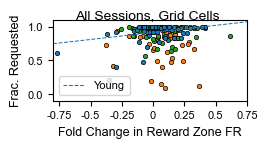

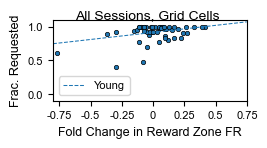

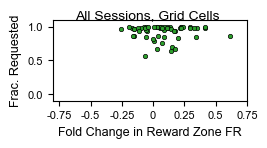

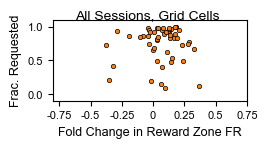


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.23689063500604862 0.25307027679143146 -0.00380500730051516 0.10288748693745636
P [Young, MA, Aged, All]: 
0.08458253968472441 0.05527624700046249 0.9780046128897352 0.18579313539555384


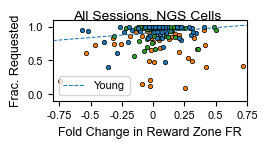

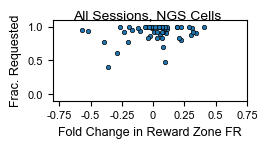

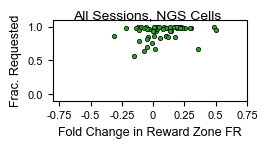

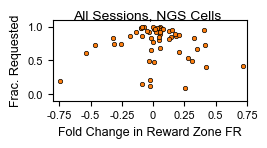

In [210]:
''' Assess & plot correlation of block performance vs. block dFR (pooling age groups) for grid & NGS cells, separately '''

#GRID CELLS
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(sdFR_grid[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

#Test outlier omission...
#res = stats.linregress(sdFR_grid[y_sindgrid][np.where(sdFR_grid[y_sindgrid] != np.min(sdFR_grid[y_sindgrid]))[0]],reqblock_rates[y_sindgrid][np.where(sdFR_grid[y_sindgrid] != np.min(sdFR_grid[y_sindgrid]))[0]])
#yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_grid[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_grid[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_grid[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.scatter(sdFR_grid[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.scatter(sdFR_grid[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + 'ReviewerFigure4H.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'ReviewerFigure4H.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure4H_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4H_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.savefig(save_folder + 'ReviewerFigure4H_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4H_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, Grid Cells', fontsize = 10)
ax.scatter(sdFR_grid[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.savefig(save_folder + 'ReviewerFigure4H_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4H_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#NGS CELLS
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sdFR_ngs[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_ngs[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_ngs[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_ngs[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.scatter(sdFR_ngs[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.scatter(sdFR_ngs[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
ax.legend(fontsize = 8)
#plt.savefig(save_folder + 'ReviewerFigure4I.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'ReviewerFigure4I.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure4I_1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4I_1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure4I_2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4I_2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('All Sessions, NGS Cells', fontsize = 10)
ax.scatter(sdFR_ngs[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Fold Change in Reward Zone FR', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-80,75])
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.set_xticklabels([-0.75,-0.50,-0.25,0,0.25,0.5,0.75])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, allslope1*X_plot + allint1, '--', color = 'k', linewidth = 0.75, label = 'All Ages')
#ax.plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', linewidth = 0.75, label = 'Young')
plt.savefig(save_folder + 'ReviewerFigure4I_3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure4I_3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [197]:
''' Checked Stats for Just First Sesssions as well...'''
#Select 1st sessions
firstsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        if (i == 0):
            firstsesh = np.append(firstsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind1st = np.intersect1d(y_sindgrid, firstsesh).astype(int)
ma_sind1st = np.intersect1d(ma_sindgrid, firstsesh).astype(int)
age_sind1st = np.intersect1d(age_sindgrid, firstsesh).astype(int)

allidx = np.concatenate((y_sind1st, ma_sind1st, age_sind1st))

#Linear regression with block data only
res = stats.linregress(sdFR_grid[y_sind1st],reqblock_rates[y_sind1st])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_grid[ma_sind1st],reqblock_rates[ma_sind1st])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_grid[age_sind1st],reqblock_rates[age_sind1st])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_grid[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

# Get indices for six sesssions in each age group
y_sind1st = np.intersect1d(y_sindngs, firstsesh).astype(int)
ma_sind1st = np.intersect1d(ma_sindngs, firstsesh).astype(int)
age_sind1st = np.intersect1d(age_sindngs, firstsesh).astype(int)

allidx = np.concatenate((y_sind1st, ma_sind1st, age_sind1st))

#Linear regression with block data only
res = stats.linregress(sdFR_ngs[y_sind1st],reqblock_rates[y_sind1st])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sdFR_ngs[ma_sind1st],reqblock_rates[ma_sind1st])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sdFR_ngs[age_sind1st],reqblock_rates[age_sind1st])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sdFR_ngs[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3733095890173132 -0.0815777978881894 -0.2164788110312998 -0.03219779454419415
P [Young, MA, Aged, All]: 
0.3623562756452975 0.8227314157216328 0.5480274627641866 0.8707949531613193

Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.1315122812829349 0.669904435166028 -0.2670568587149871 -0.10005251435211152
P [Young, MA, Aged, All]: 
0.7359168158420704 0.03406486764298399 0.4557243705887597 0.605576561908211


# NGS Cell Stability, Context-Matched Similarity, & Similarity Ratio

Figures S3i - n. You can skip to this session after setting up and loading in NGS cell booleans. 

In [86]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for NGS Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ NGS cell number).

'''

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
    
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(ngscells)))
        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allngssim'] = allsim
                               
        allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allngssim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
''' Calculate Local Cross Trial Correlation Stability within Each Context & for Block vs. Alt Phases'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#adjust loading folder path to match output of cell above
slocstab5A = []
slocstab5B = []
slocstab5A_ = []
slocstab5B_ = []
slocstab5block = []
slocstab5alt = []

mlocstab5A = []
mlocstab5B = []
mlocstab5A_ = []
mlocstab5B_ = []
max_k = 5

#cell arrays
ylocstab5A = []
ylocstab5B = []
ylocstab5A_ = []
ylocstab5B_ = []
ylocstab5block = []
ylocstab5alt = []

malocstab5A = []
malocstab5B = []
malocstab5A_ = []
malocstab5B_ = []
malocstab5block = []
malocstab5alt = []

alocstab5A = []
alocstab5B = []
alocstab5A_ = []
alocstab5B_ = []
alocstab5block = []
alocstab5alt = []

blockstability = []

for m, session in zip(mice, sessions):
    
    m_locstab5A = []
    m_locstab5B = []
    m_locstab5A_ = []
    m_locstab5B_ = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        d['allngssim'] = np.load(save_folder + allngssim_file)
        allsim = d['allngssim']
        
        local_stabilityA = []
        local_stabilityB = []
        local_stabilityA_ = []
        local_stabilityB_ = []
        local_stabilityblock = [] 
        local_stabilityalt = []
        
        for i, c in enumerate(ngscells):
            
            #divide sim by context
            sim = allsim[:,:,i]
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:(lengthA + lengthB),lengthA:(lengthA + lengthB)]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            simA_ = sim[(lengthA + lengthB):(lengthA + lengthB + lengthA_), (lengthA + lengthB):(lengthA + lengthB + lengthA_)]
            simB_ = sim[(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_),(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_)]
            
            # Context A local neighborhood 5 trials
            max_k = 5
            sum_k = np.zeros(simA.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA, offset=k)
            local_stabilityA = np.append(local_stabilityA, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 1

            #Context B
            max_k = 5
            sum_k = np.zeros(simB.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB, offset=k)
            local_stabilityB = np.append(local_stabilityB, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 2

            #Context A_
            max_k = 5
            sum_k = np.zeros(simA_.shape[0])
            
            if simA_.shape[0] <= 2*max_k:
                #print(m, s, simA_.shape[0], simB_.shape[0])
                max_k = simA_.shape[0]//2
                max_k = 3
                
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA_, offset=k)
                    
            local_stabilityA_ = np.append(local_stabilityA_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Context B_
            if simB_.shape[0] <= 10:
                print('keeping lower max k for B_...' + str(max_k))
            else: 
                max_k = 5
                
            sum_k = np.zeros(simB_.shape[0])
            
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB_, offset=k)
                    
            local_stabilityB_ = np.append(local_stabilityB_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
        m_locstab5A = np.append(m_locstab5A, local_stabilityA)
        slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
        m_locstab5B = np.append(m_locstab5B, local_stabilityB)
        slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
        m_locstab5A_ = np.append(m_locstab5A_, local_stabilityA_)    
        slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
        m_locstab5B_ = np.append(m_locstab5B_, local_stabilityB_)
        
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5A = np.append(alocstab5A, local_stabilityA) 
            alocstab5B = np.append(alocstab5B, local_stabilityB) 
            alocstab5A_ = np.append(alocstab5A_, local_stabilityA_) 
            alocstab5B_ = np.append(alocstab5B_, local_stabilityB_) 
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5A = np.append(malocstab5A, local_stabilityA) 
            malocstab5B = np.append(malocstab5B, local_stabilityB) 
            malocstab5A_ = np.append(malocstab5A_, local_stabilityA_) 
            malocstab5B_ = np.append(malocstab5B_, local_stabilityB_) 
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5A = np.append(ylocstab5A, local_stabilityA) 
            ylocstab5B = np.append(ylocstab5B, local_stabilityB) 
            ylocstab5A_ = np.append(ylocstab5A_, local_stabilityA_) 
            ylocstab5B_ = np.append(ylocstab5B_, local_stabilityB_) 
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
            
    #pool by animal
    mlocstab5A = np.append(mlocstab5A, np.nanmean(m_locstab5A))
    mlocstab5B = np.append(mlocstab5B, np.nanmean(m_locstab5B))
    mlocstab5A_ = np.append(mlocstab5A_, np.nanmean(m_locstab5A_))
    mlocstab5B_ = np.append(mlocstab5B_, np.nanmean(m_locstab5B_))

#save arrays
slocstab5A = np.asarray(slocstab5A)
slocstab5B = np.asarray(slocstab5B)
slocstab5A_ = np.asarray(slocstab5A_)
slocstab5B_ = np.asarray(slocstab5B_)
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

mlocstab5A = np.asarray(mlocstab5A)
mlocstab5B = np.asarray(mlocstab5B)
mlocstab5A_ = np.asarray(mlocstab5A_)
mlocstab5B_ = np.asarray(mlocstab5B_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3
keeping lower max k for B_...3


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [35]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []
cengageA = []
cengageB = []
cengageA_ = []
cengageB_ = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        try:
            engagement_file = 'engagement_' + str(m) + '_' + str(s) + '.npy'
            blocknclickrate = np.load(engagement_folder + engagement_file)
        
        except: #if a session's behavioral data is not used for Figure 1/S1/S2, generate engagement data. 
            speed = raw.item().get('speed')
            posx = raw.item().get('posx')
            post = raw.item().get('post')
            lick_ct = d['reward_data']['lick_ct']
            trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1)
            dt = np.unique(np.round(np.diff(post),4))
            if len(dt) > 1:
                dt = dt[dt != 0]

            # remove reward data pertaining to dark trials & skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
                nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
                k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
                keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)

            except:
                skippedtrials = []
                trial = raw.item().get('trial')
                keep_idx = (np.where(reward['trials'] > trials_dark))
                centers = np.array(reward['centers'][keep_idx])
                trials = np.array(reward['trials'][keep_idx])
                misses = reward['missed'][keep_idx].astype(bool)
                requests = ~misses 

            # get indices for reward zone (center ±25cm) & opp reward zone
            start_idx = []
            end_idx = [] 

            for t, c in zip(trials, centers):
                trial_pos = posx.copy()
                start_trial_ind = np.where(trial == t)[0][0]
                t_posx = trial_pos[trial == t]

                zone_start = c - 25 
                zone_end = c + 25

                if c == 270: 
                    oppzone_start = 370 - 25
                    oppzone_end = 370 + 25
                else: 
                    oppzone_start = 270 - 25
                    oppzone_end = 270 + 25

                s_idx = np.argmin(np.abs(t_posx - zone_start)) 
                st_idx = s_idx + start_trial_ind
                e_idx = np.argmin(np.abs(t_posx[s_idx:] - zone_end)) + st_idx

                start_idx.append(st_idx)
                end_idx.append(e_idx)

            start_idx = np.asarray(start_idx)
            end_idx = np.asarray(end_idx)

            # Remove any consummatory licks 
            nclick_ct = lick_ct.copy()
            for k in range(start_idx.shape[0]):
                st = start_idx[k]
                e = end_idx[k] + 1
                nclick_ct[st:e] = False

            # Get total nclicks/trial, save block & alternation mean for sessions, collect all values for animals
            nclickpertrial = []
            for t in trials:
                nclickpertrial = np.append(nclickpertrial, np.sum(nclick_ct[trial == t]))

            # Set up mean engagement array by context (A, B, A', B')
            blocknclickrate = []
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[trials < 81])) 
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 81) & (trials < 141)]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[0])]))
            blocknclickrate = np.append(blocknclickrate, np.mean(nclickpertrial[(trials >= 141) & (centers == centers[60])]))
        
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            cengageA = np.append(cengageA, blocknclickrate[0])
            cengageB = np.append(cengageA, blocknclickrate[1])
            cengageA_ = np.append(cengageA, blocknclickrate[2])
            cengageB_ = np.append(cengageA, blocknclickrate[3])
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
EngageA = list(cengageA)
EngageB = list(cengageB)
EngageA_ = list(cengageA_)
EngageB_ = list(cengageB_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5A
No. Observations:     6559        Method:                 REML     
No. Groups:           29          Scale:                  0.0147   
Min. group size:      65          Log-Likelihood:         1179.7480
Max. group size:      446         Converged:              Yes      
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.278    0.022 12.584 0.000  0.235  0.321
C(AgeGroup)[T.2.0]       -0.050    0.031 -1.628 0.103 -0.110  0.010
C(AgeGroup)[T.3.0]        0.052    0.026  2.033 0.042  0.002  0.103
C(Sex)[T.M]               0.050    0.030  1.677 0.094 -0.008  0.109
C(Cohort)[T.D]           -0.042    0.037 -1.132 0.258 -0.115  0

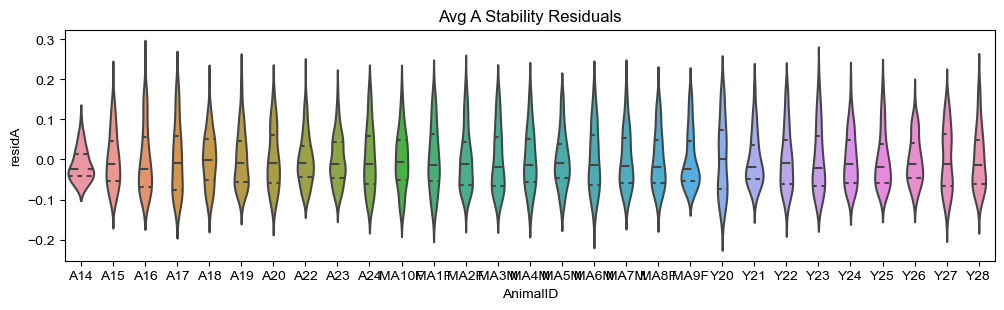

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5B
No. Observations:     6559        Method:                 REML     
No. Groups:           29          Scale:                  0.0122   
Min. group size:      65          Log-Likelihood:         1262.7772
Max. group size:      446         Converged:              No       
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.245    0.023 10.809 0.000  0.201  0.289
C(AgeGroup)[T.2.0]       -0.014    0.032 -0.441 0.659 -0.076  0.048
C(AgeGroup)[T.3.0]        0.031    0.026  1.177 0.239 -0.021  0.083
C(Sex)[T.M]               0.030    0.031  0.947 0.344 -0.032  0.091
C(Cohort)[T.D]           -0.011    0.039 -0.274 0.784 -0.086  0

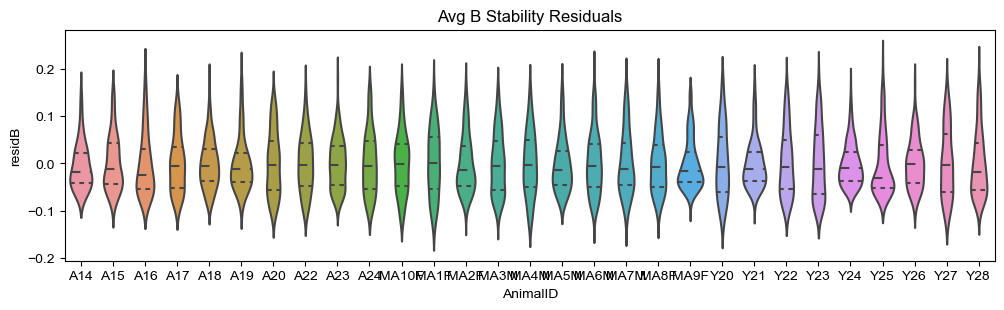

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5A_
No. Observations:      6559       Method:                REML      
No. Groups:            29         Scale:                 0.0103    
Min. group size:       65         Log-Likelihood:        2545.8482 
Max. group size:       446        Converged:             Yes       
Mean group size:       226.2                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.127    0.023  5.600 0.000  0.083  0.172
C(AgeGroup)[T.2.0]       -0.063    0.033 -1.923 0.054 -0.127  0.001
C(AgeGroup)[T.3.0]        0.062    0.027  2.310 0.021  0.009  0.114
C(Sex)[T.M]               0.036    0.033  1.086 0.278 -0.029  0.101
C(Cohort)[T.D]           -0.027    0.041 -0.663 0.507 -0.108  0

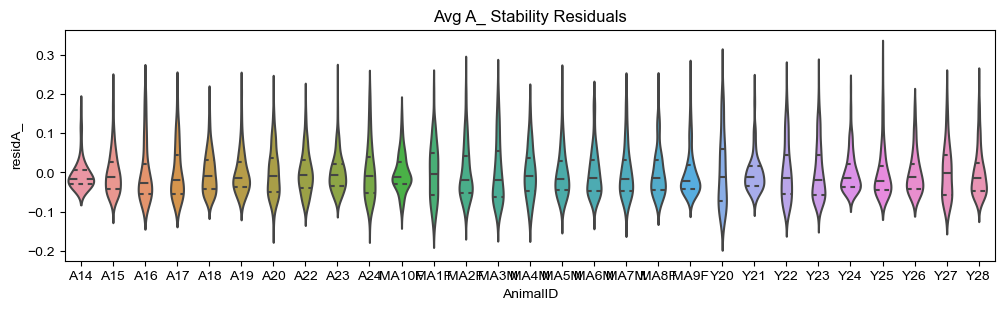

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5B_
No. Observations:      6559       Method:                REML      
No. Groups:            29         Scale:                 0.0061    
Min. group size:       65         Log-Likelihood:        2717.3113 
Max. group size:       446        Converged:             Yes       
Mean group size:       226.2                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.110    0.019  5.825 0.000  0.073  0.147
C(AgeGroup)[T.2.0]       -0.018    0.027 -0.683 0.495 -0.070  0.034
C(AgeGroup)[T.3.0]        0.048    0.022  2.155 0.031  0.004  0.091
C(Sex)[T.M]               0.047    0.026  1.796 0.073 -0.004  0.099
C(Cohort)[T.D]           -0.022    0.033 -0.672 0.501 -0.086  0

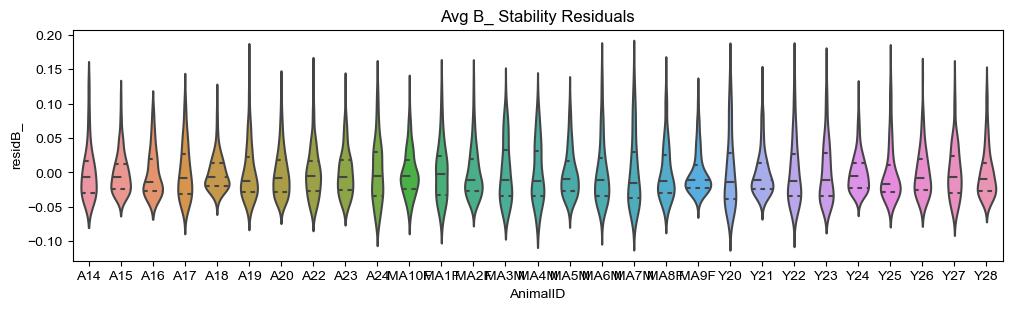

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6559      Method:               REML         
No. Groups:           29        Scale:                0.0116       
Min. group size:      65        Log-Likelihood:       2019.0985    
Max. group size:      446       Converged:            Yes          
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.250    0.020 12.604 0.000  0.211  0.289
C(AgeGroup)[T.2.0]       -0.036    0.030 -1.216 0.224 -0.094  0.022
C(AgeGroup)[T.3.0]        0.038    0.025  1.561 0.119 -0.010  0.087
C(Sex)[T.M]               0.040    0.029  1.368 0.171 -0.017  0.098
C(Cohort)[T.D]           -0.029    0.037 -0.803 0.422 -0.101  0

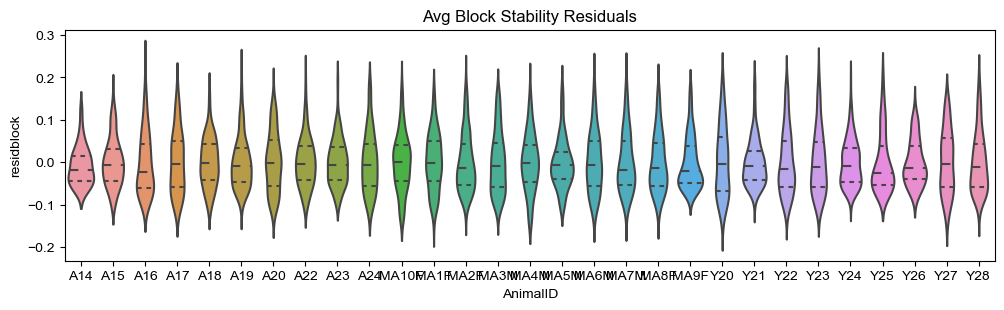

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6559       Method:                REML       
No. Groups:           29         Scale:                 0.0067     
Min. group size:      65         Log-Likelihood:        3889.8650  
Max. group size:      446        Converged:             Yes        
Mean group size:      226.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.122    0.016  7.453 0.000  0.090  0.154
C(AgeGroup)[T.2.0]       -0.035    0.024 -1.437 0.151 -0.083  0.013
C(AgeGroup)[T.3.0]        0.033    0.020  1.629 0.103 -0.007  0.072
C(Sex)[T.M]               0.031    0.025  1.245 0.213 -0.018  0.079
C(Cohort)[T.D]           -0.017    0.030 -0.570 0.569 -0.077  0

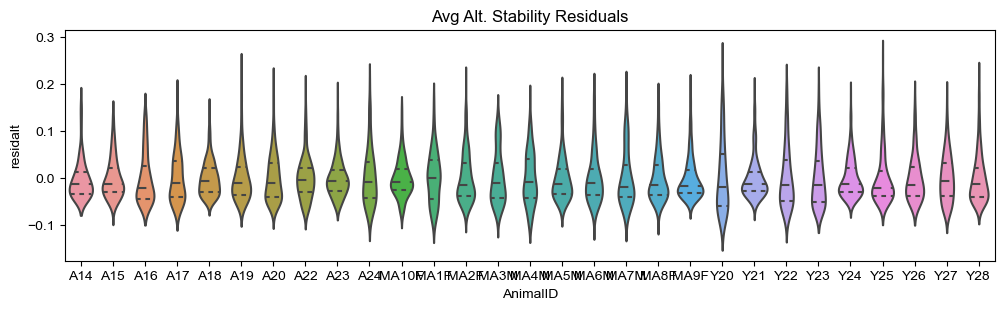

In [36]:
''' LMMs for NGS Cell Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5A = list(np.concatenate((alocstab5A, malocstab5A, ylocstab5A)))
locstab5B = list(np.concatenate((alocstab5B, malocstab5B, ylocstab5B)))
locstab5A_ = list(np.concatenate((alocstab5A_, malocstab5A_, ylocstab5A_)))
locstab5B_ = list(np.concatenate((alocstab5B_, malocstab5B_, ylocstab5B_)))
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, locstab5A, locstab5B, locstab5A_, locstab5B_,locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','locstab5A','locstab5B', 'locstab5A_', 'locstab5B_','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('locstab5A ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('Avg A Stability Residuals')
plt.show()

#B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('locstab5B ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Avg B Stability Residuals')
plt.show()

#A_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('locstab5A_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['residA_'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA_', inner = 'quartile', ax = ax)
plt.title('Avg A_ Stability Residuals')
plt.show()

#B_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('locstab5B_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['residB_'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB_', inner = 'quartile', ax = ax)
plt.title('Avg B_ Stability Residuals')
plt.show()

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [62]:
''' Get fitted session averages '''

r = 6 #sessions

df['mA_fitted'] = mA_.fittedvalues
df['mB_fitted'] = mB_.fittedvalues

resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mA_fitted'].aggregate('mean')
#print(resultA_)
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mA_fitted'])

resultB_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB_['AnimalID'])
seshBcount = np.asarray(resultB_['Session'])
seshB_mean = np.asarray(resultB_['mB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]
slocstab5B_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5B_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5B_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]
sessionBcount_fitted_aged = [[] * r for i in range(r)]
sessionBcount_fitted_MA = [[] * r for i in range(r)]
sessionBcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5B_fitted_seg_aged[idx] = np.append(slocstab5B_fitted_seg_aged[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_aged[idx] = np.append(sessionBcount_fitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_MA[idx] = np.append(slocstab5B_fitted_seg_MA[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_MA[idx] = np.append(sessionBcount_fitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_young[idx] = np.append(slocstab5B_fitted_seg_young[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_young[idx] = np.append(sessionBcount_fitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A`
10 10 9

n aged, MA, young mice on day 1 for B`
10 10 9

n aged, MA, young mice on day 2 for A`
10 10 9

n aged, MA, young mice on day 2 for B`
10 10 9

n aged, MA, young mice on day 3 for A`
10 10 9

n aged, MA, young mice on day 3 for B`
10 10 9

n aged, MA, young mice on day 4 for A`
9 10 9

n aged, MA, young mice on day 4 for B`
9 10 9

n aged, MA, young mice on day 5 for A`
8 9 9

n aged, MA, young mice on day 5 for B`
8 9 9

n aged, MA, young mice on day 6 for A`
8 9 9

n aged, MA, young mice on day 6 for B`
8 9 9


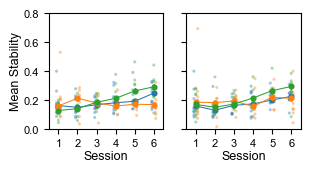

In [63]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure S3i)'''
f, ax = plt.subplots(1, 2, figsize=(3.25, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mA_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.2,0.4,0.6,0.8])
ax[0].set_ylim([0.0,0.8])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_ylim([0.0,0.8])
ax[1].set_yticks([0,0.2,0.4,0.6,0.8])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A`')
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B`')
    print(len(sessionBcount_fitted_aged[i]),len(sessionBcount_fitted_MA[i]), len(sessionBcount_fitted_young[i]))
    
    ax[0].scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcount_fitted_aged[i] + 0.1, slocstab5B_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_MA[i], slocstab5B_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_young[i] - 0.1, slocstab5B_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S3I.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3I.svg', dpi=400, bbox_inches='tight')
plt.show()

In [64]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


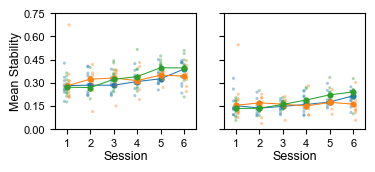

In [65]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[0].set_ylim([0.0,0.75])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[1].set_ylim([0.0,0.75])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'alt_S3I.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'alt_S3I.svg', dpi=400, bbox_inches='tight')
plt.show()

In [41]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55


Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.18607988838788747 0.627924377129172 0.4147016821536493 0.3968988514529584
P [Young, MA, Aged, All]: 
0.1779135983912671 1.3200322539791484e-07 0.001644308108671017 1.0944789594419189e-07

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.35067949836362333 0.878895310441141 0.5924459504200537 0.6500307024474653
P [Young, MA, Aged, All]: 
0.35482177627497696 0.0018043736766116484 0.1217237212071849 0.0003251509370454366


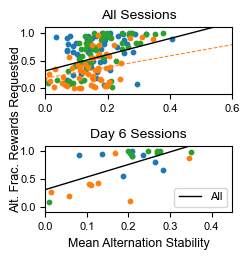

In [67]:
''' Plot Figure S3j '''
### Alt. Stability vs. REQ RATES
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression
res = stats.linregress(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
        
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)
ax[0].scatter(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax[0].scatter(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax[0].scatter(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0,0.6])
ax[0].set_yticks([0,0.5,1.0])
ax[0].tick_params(labelsize = 8)
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})

#Select 6th sessions
sixthsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    totalsesh = len(session)
    for i, s in enumerate(session):
        if (i == (totalsesh - 1)) & (totalsesh >= 6):
            sixthsesh = np.append(sixthsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind6th = np.intersect1d(y_sindngs, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindngs, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindngs, sixthsesh).astype(int)

### TOTAL ALT STABILITY vs. 6th day REQ RATES
#Linear regression
res = stats.linregress(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th,ma_sind6th,age_sind6th))
res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

# Plot Day 6 relationships
ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 10)
ax[1].scatter(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 10)
ax[1].scatter(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th], color = 'C1', s = 10)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0,0.45])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All')
ax[1].set_xlabel('Mean Alternation Stability', fontsize = 9)
ax[1].legend(loc = 4, fontsize = 8, prop = {'size': 8})

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
plt.savefig(save_folder + 'S3J.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3J.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.23147493821136603 0.5886230366289212 0.5502717239316673 0.4325718228014446
P [Young, MA, Aged, All]: 
0.09537232106918653 1.4663780506615417e-06 1.967270647844219e-05 5.2854740923709765e-09

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.18245609313185213 0.6436944876753999 0.4154894548712481 0.39689885145295833
P [Young, MA, Aged, All]: 
0.19099731307388595 6.623890256304558e-08 0.001975705664020459 1.0944789594419273e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4496502518120779 0.6518191034820533 0.6597893383907855 0.5750661092443902
P [Young, MA, Aged, All]: 
1.3289348398301994e-06 4.019716587856845e-15 1.450294831417669e-14 4.309473351107204e-30

n session halves: young, ma, aged
106 114 106


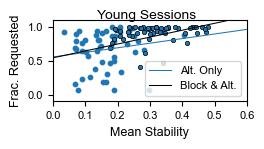

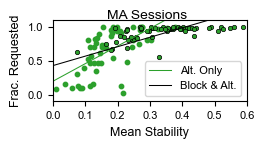

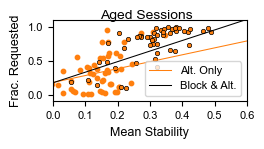

In [37]:
''' Plot Alternative Figure S3K with Block & Alt. Data '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[~np.isnan(slocstab5block)],reqblock_rates[~np.isnan(slocstab5block)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3K_alt1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3K_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3K_alt2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3K_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.6])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'S3K_alt3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3K_alt3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [38]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.spearmanr(slocstab5block[y_sindngs],reqblock_rates[y_sindngs])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(slocstab5block[age_sindngs],reqblock_rates[age_sindngs])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(slocstab5block[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(slocstab5alt[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((slocstab5block[y_sindngs],slocstab5alt[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[ma_sindngs],slocstab5alt[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[age_sindngs],slocstab5alt[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3697889321403898 0.6156701092550869 0.6288303287179591 0.48465636922826844
P [Young, MA, Aged, All]: 
0.005921575739312123 2.6954090403181727e-07 2.7305172698055344e-07 3.207337249020505e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.21670990314063257 0.6626000537397514 0.41637195815945965 0.4490858268043692
P [Young, MA, Aged, All]: 
0.11548914989065209 1.4644277967603832e-08 0.0015674581118590469 1.1485456755703555e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5696354057582976 0.7299529039827805 0.7647951363530293 0.6601770795494525
P [Young, MA, Aged, All]: 
1.2454579482570545e-10 1.465624337710457e-20 2.385124520751546e-22 3.575129956328447e-43


In [94]:
''' Calculate Spatial Avg Similarity within Each Context & on Off Diagonal'''

dt = 0.02

ystabABdiag = []
ystabBA_diag = []
ystabAB_diag = []
ystabAA_diag = []
ystabBB_diag = []

mastabABdiag = []
mastabBA_diag = []
mastabAB_diag = []
mastabAA_diag = []
mastabBB_diag = []

astabABdiag = []
astabBA_diag = []
astabAB_diag = []
astabAA_diag = []
astabBB_diag = []

sstabABdiag = []
sstabBA_diag = []
sstabAB_diag = []
sstabAA_diag = []
sstabBB_diag = []

blocksimilarity = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allngssim_file = 'allbordersim_' + m + '_' + s + '_'+ '.npy'
        d['allngssim'] = np.load(save_folder + allngssim_file)
        allngssim = d['allngssim']

        ABdiag = []
        AB_diag = []
        AA_diag = []
        BA_diag = []
        BB_diag = []
        
        for i, c in enumerate(ngscells):
            sim = allngssim[:,:,i]
            #sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))

            #divide sim by context
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:nB,lengthA:nB]
            simA_ = sim[nB:nA_,nB:nA_]
            simB_ = sim[na_:nB_,na_:nB_]
            
            # Context A spatial stability
            baseline_sim = pd.DataFrame(simA) #non-gain vs. non-gain
            baselineAstab = ((baseline_sim.sum().sum() - lengthA) / 2) / ((lengthA**2 - lengthA)/2)

            #Context B
            baseline_sim = pd.DataFrame(simB) #non-gain vs. non-gain
            baselineBstab = ((baseline_sim.sum().sum() - lengthB) / 2) / ((lengthB**2 - lengthB)/2)
            
            #Baseline Subtracted Off diagonal avg. pairwise correlation as a percentage of baseline stability
            if baselineAstab >= 0.1:
                ABdiag = np.append(ABdiag, sim[lengthA:nB, :lengthA].mean())
                AB_diag = np.append(AB_diag, sim[na_:nB_,:lengthA].mean())
                AA_diag = np.append(AA_diag, sim[nB:nA_,:lengthA].mean())
            else:
                ABdiag = np.append(ABdiag, np.nan)
                AB_diag = np.append(AB_diag, np.nan)
                AA_diag = np.append(AA_diag, np.nan)
                
            if baselineBstab >= 0.1:
                BA_diag = np.append(BA_diag, sim[nB:nA_,lengthA:nB].mean())
                BB_diag = np.append(BB_diag, sim[na_:nB_,lengthA:nB].mean())
            else:
                BA_diag = np.append(BA_diag, np.nan)
                BB_diag = np.append(BB_diag, np.nan)
                
        #Off diagonal avg. pairwise correlation
        sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
        sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
        sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A
        sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
        sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B
        
        #pool age group results
        if m in SM_aged_mice:
            astabABdiag = np.append(astabABdiag, ABdiag)
            astabBA_diag = np.append(astabBA_diag, BA_diag)
            astabAB_diag = np.append(astabAB_diag, AB_diag)
            astabAA_diag = np.append(astabAA_diag, AA_diag)
            astabBB_diag = np.append(astabBB_diag, BB_diag)
        elif m in SM_MA_mice:
            mastabABdiag = np.append(mastabABdiag, ABdiag)
            mastabBA_diag = np.append(mastabBA_diag, BA_diag)
            mastabAB_diag = np.append(mastabAB_diag, AB_diag)
            mastabAA_diag = np.append(mastabAA_diag, AA_diag)
            mastabBB_diag = np.append(mastabBB_diag, BB_diag)
        else:
            ystabABdiag = np.append(ystabABdiag, ABdiag)
            ystabBA_diag = np.append(ystabBA_diag, BA_diag)
            ystabAB_diag = np.append(ystabAB_diag, AB_diag)
            ystabAA_diag = np.append(ystabAA_diag, AA_diag)
            ystabBB_diag = np.append(ystabBB_diag, BB_diag)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:108: RuntimeWarning: Mean of empty slice
  sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:109: RuntimeWarning: Mean of empty slice
  sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:110: RuntimeWarning: Mean of empty slice
  sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:111: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:112: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:111: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:112: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:111: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:112: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:108: RuntimeWarning: Mean of empty slice
  sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:109: RuntimeWarning: Mean of empty slice
  sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\1311093367.py:110: RuntimeWarning: Mean of empty slice
  sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     stabABdiag
No. Observations:      4378        Method:                 REML      
No. Groups:            29          Scale:                  0.0066    
Min. group size:       27          Log-Likelihood:         1485.5374 
Max. group size:       302         Converged:              Yes       
Mean group size:       151.0                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.182    0.026  7.080 0.000  0.132  0.232
C(AgeGroup)[T.2.0]         -0.059    0.036 -1.629 0.103 -0.129  0.012
C(AgeGroup)[T.3.0]         -0.038    0.030 -1.256 0.209 -0.096  0.021
C(Sex)[T.M]                 0.031    0.036  0.863 0.388 -0.039  0.101
C(Cohort)[T.D]             -0.055   

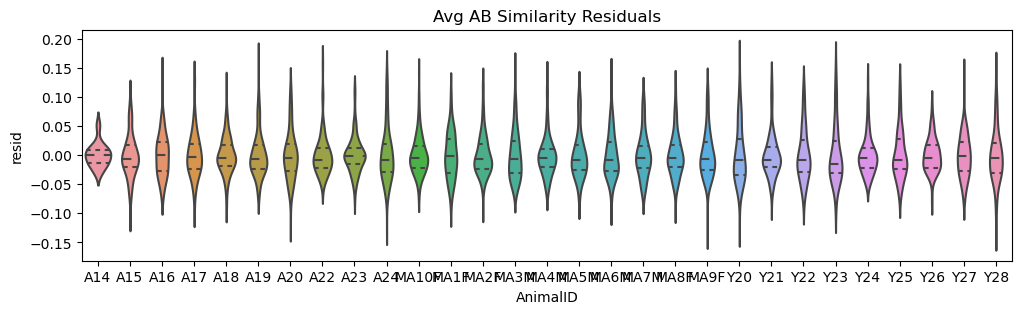

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     stabAA_  
No. Observations:     4378        Method:                 REML     
No. Groups:           29          Scale:                  0.0093   
Min. group size:      27          Log-Likelihood:         1870.7140
Max. group size:      302         Converged:              Yes      
Mean group size:      151.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.143    0.023  6.342 0.000  0.099  0.187
C(AgeGroup)[T.2.0]       -0.026    0.031 -0.818 0.413 -0.087  0.036
C(AgeGroup)[T.3.0]        0.005    0.026  0.206 0.837 -0.046  0.057
C(Sex)[T.M]               0.018    0.031  0.586 0.558 -0.042  0.078
C(Cohort)[T.D]           -0.032    0.038 -0.823 0.410 -0.106  0

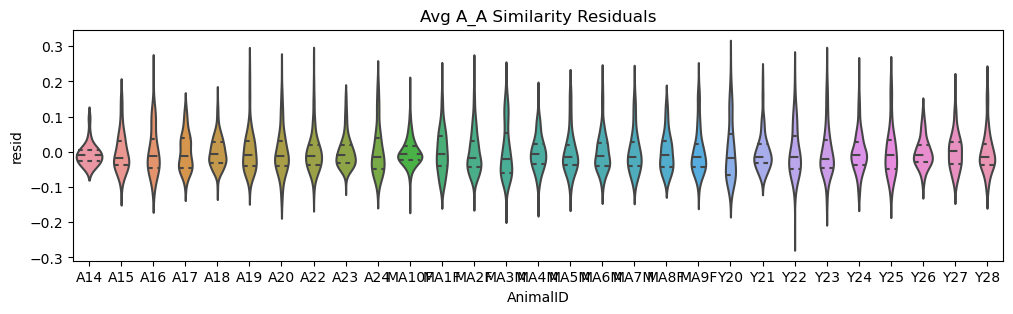

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     stabBB_  
No. Observations:     4378        Method:                 ML       
No. Groups:           29          Scale:                  0.0047   
Min. group size:      27          Log-Likelihood:         1953.0575
Max. group size:      302         Converged:              Yes      
Mean group size:      151.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.180    0.030  6.036 0.000  0.121  0.238
C(AgeGroup)[T.2.0]       -0.020    0.043 -0.464 0.642 -0.105  0.065
C(AgeGroup)[T.3.0]       -0.004    0.035 -0.102 0.919 -0.072  0.065
C(Sex)[T.M]               0.018    0.044  0.411 0.681 -0.068  0.105
C(Cohort)[T.D]           -0.021    0.055 -0.389 0.697 -0.129  0

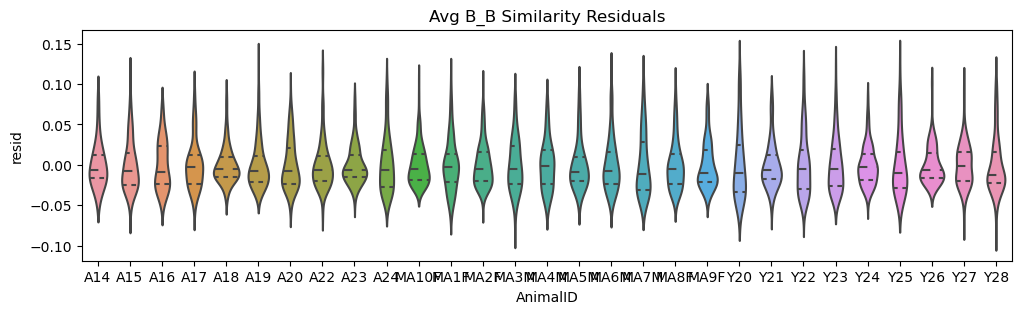

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     stabAB_  
No. Observations:       4378        Method:                 REML     
No. Groups:             29          Scale:                  0.0046   
Min. group size:        27          Log-Likelihood:         2287.8863
Max. group size:        302         Converged:              Yes      
Mean group size:        151.0                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.111    0.021  5.177 0.000  0.069  0.153
C(AgeGroup)[T.2.0]         -0.035    0.030 -1.152 0.249 -0.093  0.024
C(AgeGroup)[T.3.0]         -0.005    0.025 -0.206 0.836 -0.054  0.044
C(Sex)[T.M]                 0.034    0.030  1.149 0.251 -0.024  0.092
C(Cohort)[T.D]             -0.039   

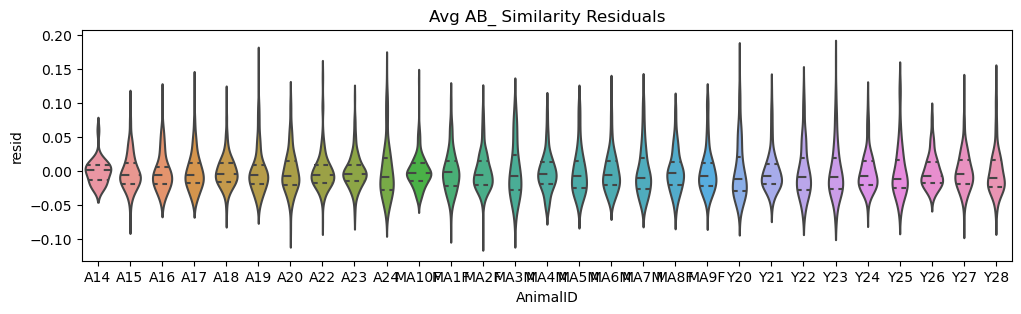

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     stabBA_  
No. Observations:       4378        Method:                 ML       
No. Groups:             29          Scale:                  0.0042   
Min. group size:        27          Log-Likelihood:         2158.3323
Max. group size:        302         Converged:              No       
Mean group size:        151.0                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.141    0.030  4.764 0.000  0.083  0.198
C(AgeGroup)[T.2.0]         -0.036    0.043 -0.842 0.400 -0.120  0.048
C(AgeGroup)[T.3.0]         -0.014    0.035 -0.401 0.688 -0.082  0.054
C(Sex)[T.M]                 0.020    0.044  0.454 0.650 -0.066  0.106
C(Cohort)[T.D]             -0.030   

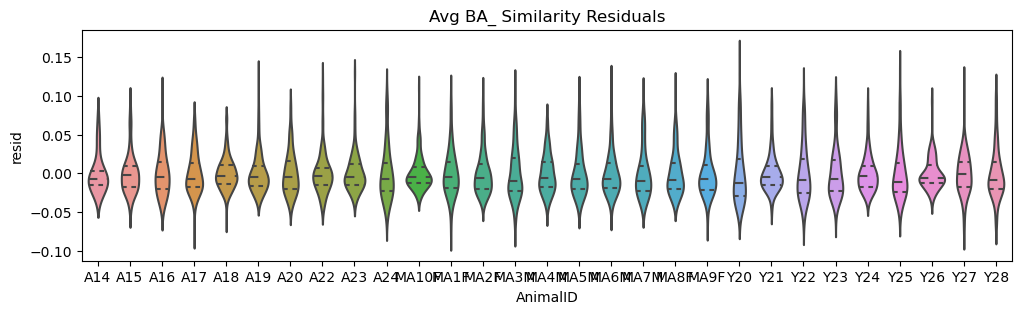

In [95]:
''' LMMs for Avg Similarity On Diag '''   
hue_order = [1.0,3.0,2.0]
#gather dependent variables into lists
stabABdiag = list(np.concatenate((astabABdiag, mastabABdiag, ystabABdiag)))
stabAA_diag = list(np.concatenate((astabAA_diag, mastabAA_diag, ystabAA_diag)))
stabBB_diag = list(np.concatenate((astabBB_diag, mastabBB_diag, ystabBB_diag)))
stabAB_diag = list(np.concatenate((astabAB_diag, mastabAB_diag, ystabAB_diag)))
stabBA_diag = list(np.concatenate((astabBA_diag, mastabBA_diag, ystabBA_diag)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, stabABdiag, stabAA_diag, stabBB_diag,stabAB_diag,stabBA_diag))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','stabABdiag','stabAA_', 'stabBB_','stabAB_','stabBA_'])

#handle NaNs
df = df.dropna(axis = 0)

# AB Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('stabABdiag ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg AB Similarity Residuals')
plt.show()

# A_A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('stabAA_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['resid'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg A_A Similarity Residuals')
plt.show()

# B_B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('stabBB_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['resid'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg B_B Similarity Residuals')
plt.show()

# AB_Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('stabAB_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['resid'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg AB_ Similarity Residuals')
plt.show()

# BA_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('stabBA_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['resid'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg BA_ Similarity Residuals')
plt.show()

In [96]:
''' Get fitted session averages '''

df['mAfitted'] = mA.fittedvalues
df['mBfitted'] = mB.fittedvalues

resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAfitted'])

resultB_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mBfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB_['AnimalID'])
seshBcount = np.asarray(resultB_['Session'])
seshB_mean = np.asarray(resultB_['mBfitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]
slocstab5B_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5B_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5B_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]
sessionBcount_fitted_aged = [[] * r for i in range(r)]
sessionBcount_fitted_MA = [[] * r for i in range(r)]
sessionBcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5B_fitted_seg_aged[idx] = np.append(slocstab5B_fitted_seg_aged[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_aged[idx] = np.append(sessionBcount_fitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_MA[idx] = np.append(slocstab5B_fitted_seg_MA[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_MA[idx] = np.append(sessionBcount_fitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_young[idx] = np.append(slocstab5B_fitted_seg_young[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_young[idx] = np.append(sessionBcount_fitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for AxA`
9 10 8

n aged, MA, young mice on day 1 for BxB`
9 10 8

n aged, MA, young mice on day 2 for AxA`
9 10 9

n aged, MA, young mice on day 2 for BxB`
9 10 9

n aged, MA, young mice on day 3 for AxA`
10 10 9

n aged, MA, young mice on day 3 for BxB`
10 10 9

n aged, MA, young mice on day 4 for AxA`
9 10 9

n aged, MA, young mice on day 4 for BxB`
9 10 9

n aged, MA, young mice on day 5 for AxA`
8 9 9

n aged, MA, young mice on day 5 for BxB`
8 9 9

n aged, MA, young mice on day 6 for AxA`
8 8 9

n aged, MA, young mice on day 6 for BxB`
8 8 9


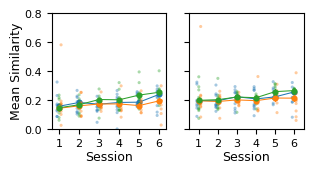

In [97]:
''' Plot Figure S3k '''
f, ax = plt.subplots(1, 2, figsize=(3.25, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mA.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[0].set_ylabel('Mean Similarity', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
ax[0].tick_params(labelsize = 8)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_ylim([0,0.8])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for AxA`')
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for BxB`')
    print(len(sessionBcount_fitted_aged[i]),len(sessionBcount_fitted_MA[i]), len(sessionBcount_fitted_young[i]))
    
    ax[0].scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcount_fitted_aged[i] + 0.1, slocstab5B_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_MA[i], slocstab5B_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_young[i] - 0.1, slocstab5B_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)
    
#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S3K.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3K.svg', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Python\AppData\Local\Temp\ipykernel_8356\329899885.py:3: RuntimeWarning: Mean of empty slice
  sstabalt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)
C:\Users\Python\AppData\Local\Temp\ipykernel_8356\329899885.py:40: RuntimeWarning: Mean of empty slice
  slocstab5alt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)


Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.33121679237628254 0.6123930242919673 0.3513676404032054 0.38233682699280613
P [Young, MA, Aged, All]: 
0.014426052835604955 3.2457338631489323e-07 0.009180848672739403 3.708941724271689e-07

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.12488723534074184 0.882549367375184 0.6343572750571127 0.6129139506083764
P [Young, MA, Aged, All]: 
0.748865410293143 0.0016269280175198362 0.09114777980563382 0.0008718098378111426


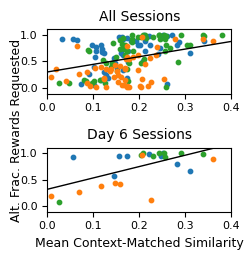

In [98]:
''' Plot Figure S3l '''
### TOTAL ALT vs. REQ RATES
sstabalt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)

#Linear regression
res = stats.linregress(sstabalt[y_sindngs],reqalt_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sstabalt[ma_sindngs],reqalt_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sstabalt[age_sindngs][~np.isnan(sstabalt[age_sindngs])],reqalt_rates[age_sindngs][~np.isnan(sstabalt[age_sindngs])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sstabalt[~np.isnan(sstabalt)],reqalt_rates[~np.isnan(sstabalt)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
    
#plot top half    
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)
ax[0].scatter(sstabalt[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax[0].scatter(sstabalt[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax[0].scatter(sstabalt[age_sindngs][~np.isnan(sstabalt[age_sindngs])],reqalt_rates[age_sindngs][~np.isnan(sstabalt[age_sindngs])], color = 'C1', s = 10)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_yticks([0,0.5,1.0])
ax[0].set_xlim([0,0.4])
ax[0].tick_params(labelsize = 8)
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
#ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 1, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#Gather 6th session data
slocstab5alt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)

#Linear regression
res = stats.linregress(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sind6th][~np.isnan(slocstab5alt[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(slocstab5alt[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 10)
ax[1].scatter(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 10)
ax[1].scatter(slocstab5alt[age_sind6th][~np.isnan(slocstab5alt[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(slocstab5alt[age_sind6th])], color = 'C1', s = 10)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0,0.4])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
ax[1].set_xlabel('Mean Context-Matched Similarity', fontsize = 9)
plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
plt.savefig(save_folder + 'S3L.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3L.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [39]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allngssim = d['allngssim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(ngscells):
            sim = allngssim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ABratio 
No. Observations:      6559        Method:                 REML    
No. Groups:            29          Scale:                  0.0170  
Min. group size:       65          Log-Likelihood:         755.6985
Max. group size:       446         Converged:              Yes     
Mean group size:       226.2                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.102    0.024 46.716 0.000  1.056  1.149
C(AgeGroup)[T.2.0]        0.010    0.035  0.296 0.767 -0.058  0.079
C(AgeGroup)[T.3.0]        0.059    0.029  2.008 0.045  0.001  0.117
C(Sex)[T.M]              -0.012    0.035 -0.337 0.736 -0.080  0.057
C(Cohort)[T.D]            0.036    0.043  0.843 0.399 -0.048  0

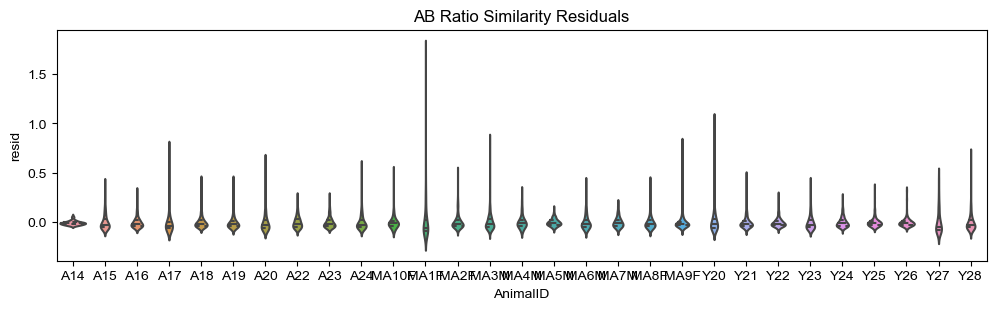

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     A_B_ratio
No. Observations:      6559        Method:                 REML     
No. Groups:            29          Scale:                  0.0024   
Min. group size:       65          Log-Likelihood:         7107.4459
Max. group size:       446         Converged:              Yes      
Mean group size:       226.2                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.023    0.009 116.257 0.000  1.006  1.040
C(AgeGroup)[T.2.0]        0.006    0.013   0.446 0.655 -0.020  0.032
C(AgeGroup)[T.3.0]        0.037    0.011   3.396 0.001  0.016  0.059
C(Sex)[T.M]              -0.004    0.013  -0.318 0.750 -0.030  0.021
C(Cohort)[T.D]            0.012    0.016   0.726 0

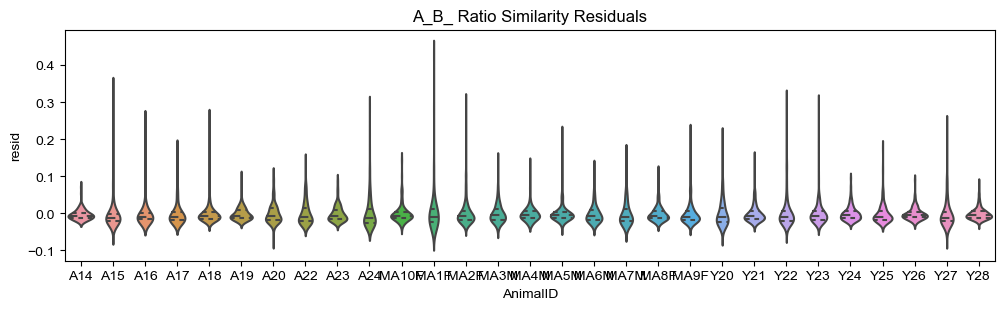

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     AB_ratio 
No. Observations:      6559        Method:                 REML     
No. Groups:            29          Scale:                  0.0029   
Min. group size:       65          Log-Likelihood:         6591.7103
Max. group size:       446         Converged:              Yes      
Mean group size:       226.2                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.022    0.010 105.902 0.000  1.003  1.041
C(AgeGroup)[T.2.0]        0.014    0.014   0.972 0.331 -0.014  0.042
C(AgeGroup)[T.3.0]        0.017    0.012   1.438 0.151 -0.006  0.041
C(Sex)[T.M]              -0.012    0.014  -0.809 0.419 -0.039  0.016
C(Cohort)[T.D]            0.012    0.018   0.666 0

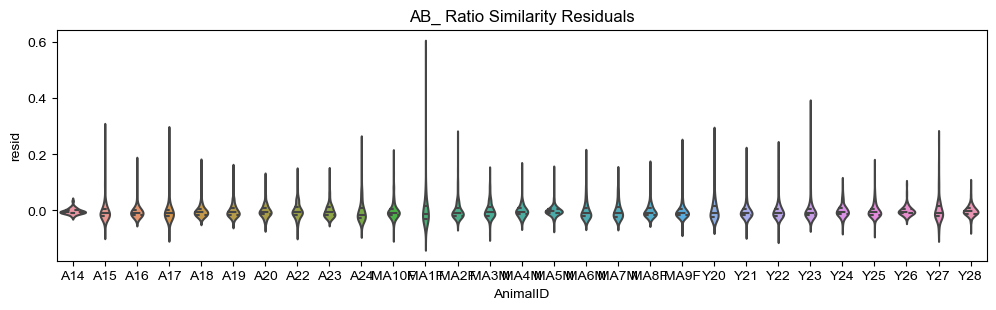

In [40]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [71]:
''' Get fitted session averages '''

df['mAB_fitted'] = mAB_.fittedvalues
resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    
    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
   
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
             
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            


aged, MA, young mice on day 1
10 10 9

aged, MA, young mice on day 2
10 10 9

aged, MA, young mice on day 3
10 10 9

aged, MA, young mice on day 4
9 10 9

aged, MA, young mice on day 5
8 9 9

aged, MA, young mice on day 6
8 9 9


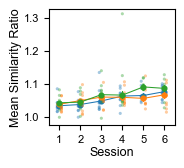

In [72]:
''' Plot Figure S3m '''
f, ax = plt.subplots(1, 1, figsize=(1.625, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_ylim([0.975,1.325])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\naged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    ax.scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#ax.legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'S3M.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S3M.svg', dpi=400, bbox_inches='tight')
plt.show()

In [73]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 9

n aged, MA, young mice on day 1 for alt ratio
10 10 9

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
10 10 9

n aged, MA, young mice on day 3 for alt ratio
10 10 9

n aged, MA, young mice on day 4 for block ratio
9 10 9

n aged, MA, young mice on day 4 for alt ratio
9 10 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
8 9 9

n aged, MA, young mice on day 6 for alt ratio
8 9 9


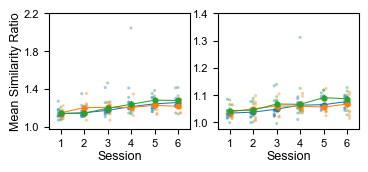

In [74]:
'''Plot Alt. Figure SJ (Mean Similarity Ratio)'''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.4,1.8,2.2])
ax[0].set_ylim([0.975,2.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3,1.4])
ax[1].set_ylim([0.975,1.4])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'alt_S3J.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'alt_S3J.svg', dpi=400, bbox_inches='tight')
plt.show()

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.546451559802995 0.4579888838000001 0.4894423658179412 0.4779044928796678
P [Young, MA, Aged, All]: 
1.9143704287716738e-05 0.0003003621569441944 0.00014930947290988584 6.531463338208855e-11

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.1827993015484762 0.6728468269165566 0.7541082330253633 0.647591798615133
P [Young, MA, Aged, All]: 
0.6378188610519764 0.04702436209990243 0.03065080926267908 0.00034830355131399966


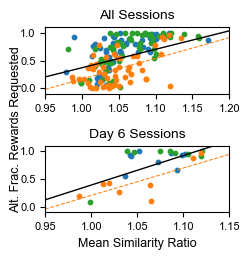

In [75]:
''' Plot Figure S3N'''
### A_ vs. REQ ALT RATES
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression
res = stats.linregress(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindngs][~np.isnan(sAB_ratio[age_sindngs])],reqalt_rates[age_sindngs][~np.isnan(sAB_ratio[age_sindngs])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
 
#plot all session correlations
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)

ax[0].scatter(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', label = 'Young', s = 10)
ax[0].scatter(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', label = 'MA', s = 10)
ax[0].scatter(sAB_ratio[age_sindngs][~np.isnan(sAB_ratio[age_sindngs])],reqalt_rates[age_sindngs][~np.isnan(sAB_ratio[age_sindngs])], color = 'C1', s = 10)
ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0.95,1.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,0.5,1.0])
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#day 6 data
### ALT Stability vs. REQ RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th[~np.isnan(sAB_ratio[y_sind6th])],ma_sind6th[~np.isnan(sAB_ratio[ma_sind6th])],age_sind6th[~np.isnan(sAB_ratio[age_sind6th])]))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])], color = 'C0', s = 10)
ax[1].scatter(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])], color = 'C2', s = 10)
ax[1].scatter(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])], color = 'C1', s = 10)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0.95,1.15])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
plt.savefig(save_folder + 'S3N.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3N.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3893391243173612 0.36874504023109245 0.6522506106051179 0.3915512286955412
P [Young, MA, Aged, All]: 
0.003615741807794011 0.004395844935643074 6.851912609075353e-08 1.6732953259645066e-07

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.546451559802995 0.4579888838000001 0.4894423658179412 0.4779044928796678
P [Young, MA, Aged, All]: 
1.9143704287716738e-05 0.0003003621569441944 0.00014930947290988584 6.531463338208855e-11

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5397208737033234 0.4236515560659057 0.7460761291176724 0.519911894599628
P [Young, MA, Aged, All]: 
1.6647646464687428e-09 2.152183059726853e-06 8.58520966622007e-21 1.5951652283656927e-24

n session halves: young, ma, aged
108 116 110


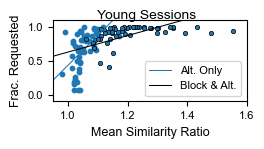

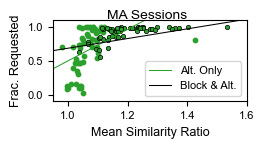

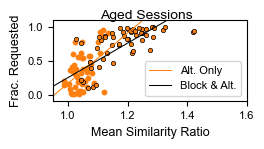

In [41]:
''' Plot Alternative Figure 2I with Block Data '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue; ap3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3L_alt1.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3L_alt1.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'S3L_alt2.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3L_alt2.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6,])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'S3L_alt3.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S3L_alt3.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [42]:
''' Check Spearmann Correlations'''

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.spearmanr(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yr1 = res.statistic; yp1 = res.pvalue

res = stats.spearmanr(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
mar1 = res.statistic ; map1 = res.pvalue

res = stats.spearmanr(sABratio[age_sindngs],reqblock_rates[age_sindngs])
ar1 = res.statistic ; ap1 = res.pvalue

res = stats.spearmanr(sABratio[allidx],reqblock_rates[allidx])
allr1 = res.statistic; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.spearmanr(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yr2 = res.statistic; yp2 = res.pvalue

res = stats.spearmanr(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
mar2 = res.statistic ; map2 = res.pvalue

res = stats.spearmanr(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
ar2 = res.statistic ; ap2 = res.pvalue

res = stats.spearmanr(sAB_ratio[allidx],reqalt_rates[allidx])
allr2 = res.statistic; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.spearmanr(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yr3 = res.statistic; yp3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
mar3 = res.statistic ; map3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
ar3 = res.statistic ; ap3 = res.pvalue

res = stats.spearmanr(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allr3 = res.statistic; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5940934430433976 0.7026508340955865 0.7084852983259792 0.6298244887360492
P [Young, MA, Aged, All]: 
2.1813826340754256e-06 7.848314700897572e-10 1.437479553226705e-09 7.668379221029698e-20

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.6229027393634056 0.6558514065548846 0.37493688465329983 0.5863135835841041
P [Young, MA, Aged, All]: 
4.908223776932731e-07 2.2970050254109503e-08 0.004796015272043836 8.453829804795797e-17

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.7346920784911704 0.6887749076943185 0.7744575385013623 0.7239267969149324
P [Young, MA, Aged, All]: 
1.4333134238093943e-19 1.2801068104429666e-17 3.2847393527983945e-23 1.7878321198739654e-55
